# Entrega 1: Ejercicio 2. 

**Asignatura**: Machine Learning, 2025/2026

**Profesora**: Raquel Martinez España

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#introducción)
   1. [Problema](#problema)
   2. [Metodología](#metodologia)
2. [Análisis del dataset y preprocesamiento básico.](#dataset)
   1. [Balanceo de datos](#balanceo)
   2. [Tratamiento de outliers y normalización](#outliers)
3. [Entrenamiento de modelo baseline](#linea-base)
4. [Estrategias de validación y evaluación](#evaluacion)
5. [Entrenamiento de modelos más robustos](#entrenamiento)
   1. [Extra-trees](#trees)
   2. [XGBoost](#xgboost)
   3. [MLP](#mlp)
6. [Extracción de características](#caracteristicas)
   1. [Extra-trees](#trees-1)
   2. [XGBoost](#xgboost-1)
   3. [MLP](#mlp-1)
7. [Balanceo de datos](#balanceo-2)
   1. [Extra-trees](#trees-2)
   2. [XGBoost](#xgboost-2)
   3. [MLP](#mlp-2)
8. [Balanceo de datos con extracción de características](#balanceo-caracteristicas)
9. [Optimización de hiperparámetros de los modelos](#hyper)
   1. [Extra-trees](#trees-3)
   2. [XGBoost](#xgboost-3)
   3. [MLP](#mlp-3)
10. [Construcción de modelo híbrido](#hibrido)
11. [Elección del mejor modelo](#eleccion)
12. [Conclusión](#conclusion)
   
 [Uso de IA Generativa](#generativa)

 [Librerías utilizadas](#librerias)
 

## Introducción <a class="anchor" id="introduccion"></a>

En este segundo problema, tenemos un problema médico multietiqueta. Tendremos que crear un sistema de clasificación y predicción de enfermedades en base a un dataset de proteínas.

### Problema <a class="anchor" id="problema"></a>

Tenemos un dataset formado por muestras de proteínas celulares y las enfermedades asociadas a cada conjunto de ellas. Cada columna corresponderá con una medida recogida acerca de una proteína concreta. Se trata de un problema multietiqueta. Esto quiere decir que para cada conjunto de proteínas en cada instancia, tendremos varias clases a las que esta pueda pertenecer. Cada una de las clases se corresponderá con las enfermedades asociadas a una muestra y tendremos un valor binario (0 ó 1) que nos indicará si dicha enfermedad se encuentra presente. 

### Metodología <a class="anchor" id="metodologia"></a>

Por ser este un problema multietiqueta, seguiremos una metodología algo distinta a la del problema anterior. El flujo de trabajo a seguir será el siguiente: 

1. **Análisis del dataset y preprocesamiento básico.** Observaremos cómo está construido el dataset y analizaremos la distribución de variables numéricas y categóricas, el porcentaje de valores nulos, la presencia de ruido o inconsistencias y las correlaciones y balance entre clases.

2. **Entrenamiento de modelo de línea base.** Entrenaremos un primer modelo que usaremos como línea base para nuestro problema. Escogeremos un modelo explicable y fácilmente computable cuyo rendimiento intentaremos superar con el resto de modelos entrenados.

3. **Definición de estrategias de validación y evaluación.** Una vez analizado el problema, definiremos qué métricas y qué estrategias seguiremos para evaluar y validar los modelos.

4. **Entrenamiento de modelos principales.** Procederemos entonces a entrenar los modelos escogidos como principales para resolver nuestro problema de clasificación multietiqueta usando sus parámetros por defecto.

5. **Extracción de características.** A continuación, en vez de realizar selección de características, intentaremos realizar una extracción de las mismas para poder reducir la dimensionalidad de nuestro dataset de proteínas. Comprobaremos si conseguimos así quedarnos con un espacio de dimensiones más reducido y que contenga la información más relevante para nuestro problema.

6. **Balanceo de datos**.  Una vez determinado si existe desbalanceo de los datos, intentaremos buscar una técnica adecuada de balanceo para problemas multietiqueta. Deberemos tener en cuenta en esta ocasión, que las instancias creadas deben tener varias clases y que han de respetar las distribuciones originales de las mismas. Utilizaremos aquella que concluyamos que es mejor para balancear, aumentando las instancias de las clases minoritarias con respecto a las mayoritarias. 

7. **Balanceo de datos con extracción de características**. Intentaremos ver si es posible combinar la extracción de características con las técnicas de balanceo de datos.

8. **Búsqueda y ajuste de hiperparámetros.** En esta etapa, entrenaremos los modelos principales elegidos haciendo un ajuste fino de hiperparámetros para preparar los modelos finales.

9. **Construcción de modelo híbrido.** Para intentar mejorar aún más el rendimiento de los modelos finales entrenados, intentaremos crear un modelo híbrido formado por dos clasificadores. 

10. **Comparación y elección del mejor modelo.** Por último, compararemos todos los modelos y los resultados obtenidos, además de entrenar el modelo final.



# Análisis del dataset y preprocesamiento básico. <a class="anchor" id="dataset"></a>

 Lo primero que hacemos es importar las librerías y cargar los datos de nuestro problema.

In [1]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import math
import random
from sklearn.metrics import hamming_loss,f1_score,jaccard_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier



# display all columns
pd.set_option('display.max_columns', None)

#Semilla establecida
semilla=123
np.random.seed(semilla)
#Establecemos semilla para los random 
random.seed(semilla)


# Cargamos la base de datos de proteinas.csv
url = ( './proteinas/proteinas.csv')
url2 = ( './proteinas/proteinas.name')

columnas = []

# Código de lectura del archivo .name para extraer los nombres de las columnas
# Consultado a chatGPT
with open(url2, "r") as f:
    for line in f:
        line = line.strip()
        if line.lower().startswith("@attribute"):
            # Separa la línea por espacios
            partes = line.split()
            # El nombre del atributo es la segunda parte
            nombre = partes[1]
            columnas.append(nombre)

proteinas = pd.read_csv(url, sep=',', header=None, names=columnas)
# Damos un vistazo rápido sobre cómo está construido el dataset en las primeras filas
proteinas.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,Att19,Att20,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,Att38,Att39,Att40,Att41,Att42,Att43,Att44,Att45,Att46,Att47,Att48,Att49,Att50,Att51,Att52,Att53,Att54,Att55,Att56,Att57,Att58,Att59,Att60,Att61,Att62,Att63,Att64,Att65,Att66,Att67,Att68,Att69,Att70,Att71,Att72,Att73,Att74,Att75,Att76,Att77,Att78,Att79,Att80,Att81,Att82,Att83,Att84,Att85,Att86,Att87,Att88,Att89,Att90,Att91,Att92,Att93,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,-0.027230,-0.137411,0.067776,0.047175,0.155671,0.050766,0.102557,-0.020259,-0.200512,-0.095371,-0.081940,-0.103735,0.093299,0.105475,0.148560,0.085925,0.107879,0.108075,0.085388,0.124026,-0.003650,-0.127376,0.039394,-0.018364,0.050378,0.157190,0.203563,0.111552,0.017907,-0.001126,0.053062,0.140708,0.137118,-0.090282,-0.067809,-0.102396,-0.051758,0.050665,0.007055,0.021674,0.061283,0.083523,0.053235,0.001978,0.077418,0.046762,-0.075730,-0.092787,0.127297,-0.178029,-0.202705,-0.028543,0.032891,0.023189,0.009716,-0.169848,-0.002261,-0.133029,0.082378,-0.216610,0.062425,-0.128243,0.203676,0.143642,0.178602,0.192041,0.154135,-0.175325,-0.133636,0.005524,-0.014981,-0.031946,-0.015114,-0.047175,0.003829,0.010967,-0.006062,-0.027560,-0.019866,-0.024046,-0.025153,-0.009261,-0.025539,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,-0.215304,-0.009885,-0.155843,-0.059522,-0.098836,-0.071141,-0.023494,-0.071200,0.027767,0.003091,-0.003761,0.074600,0.053080,-0.008138,0.001794,-0.111704,-0.140291,-0.063347,0.066767,-0.167073,-0.095567,-0.047209,0.082206,0.144445,0.086581,-0.111850,-0.086560,0.024942,-0.131539,0.080062,0.345095,-0.090835,-0.072651,0.045934,0.016653,-0.091120,0.024707,-0.058299,0.027210,0.004696,0.013844,0.043541,0.044008,0.036480,0.039348,-0.046261,0.025664,0.016511,0.043803,0.019016,-0.018508,-0.042825,-0.127017,0.383213,0.027688,0.179844,-0.019807,0.031726,-0.086455,0.157766,-0.016577,0.028003,-0.042753,-0.083054,-0.035512,-0.008779,-0.050616,-0.001249,-0.020209,-0.077359,-0.045139,-0.074738,0.051846,0.009323,0.184332,0.420424,-0.090224,-0.090718,-0.035266,-0.046729,0.000575,-0.066023,-0.051916,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,-0.040576,0.014326,-0.074968,0.141365,-0.015182,0.013691,0.006893,0.003736,-0.020726,-0.044104,-0.052959,-0.085572,-0.061547,-0.029578,0.027700,-0.094310,-0.047721,-0.081589,-0.022846,-0.106684,-0.068873,-0.105225,-0.065414,-0.047722,-0.070723,-0.057425,-0.042024,-0.034122,-0.049606,0.015137,-0.091978,-0.057454,0.039602,0.028388,-0.068859,-0.027863,-0.061797,-0.059999,-0.033393,0.017728,0.097745,0.039449,0.041347,-0.083136,0.052164,0.000810,0.018361,0.037830,-0.029845,-0.031345,0.026966,0.051128,-0.015953,-0.002294,-0.046697,-0.000500,0.034184,-0.033345,-0.007070,-0.002837,0.001422,0.005147,-0.138257,-0.096135,-0.055102,0.000830,-0.047025,-0.002432,0.001711,-0.083572,-0.096943,0.148457,-0.007413,0.130691,-0.032325,0.028612,-0.023051,-0.092214,-0.103336,0.138232,-0.100351,0.140423,0.110074,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,-0.013027,0.045538,0.080412,-0.010042,0.013029,-0.071975,0.089818,-0.016129,0.033105,0.024275,0.040428,0.064248,0.225613,0.176576,0.015501,0.009491

Una vez cargados los datos, observamos la forma de los mismos.

In [2]:
# información del dataset mostrando el nombre de cada columna, su tipo, y de cuántas filas tiene el dataset y cada una de las variables, siendo con estas ultimas la cantidad de no nulas 

proteinas.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 117 columns):
 #    Column   Non-Null Count  Dtype  
---   ------   --------------  -----  
 0    Att1     2417 non-null   float64
 1    Att2     2417 non-null   float64
 2    Att3     2417 non-null   float64
 3    Att4     2417 non-null   float64
 4    Att5     2417 non-null   float64
 5    Att6     2417 non-null   float64
 6    Att7     2417 non-null   float64
 7    Att8     2417 non-null   float64
 8    Att9     2417 non-null   float64
 9    Att10    2417 non-null   float64
 10   Att11    2417 non-null   float64
 11   Att12    2417 non-null   float64
 12   Att13    2417 non-null   float64
 13   Att14    2417 non-null   float64
 14   Att15    2417 non-null   float64
 15   Att16    2417 non-null   float64
 16   Att17    2417 non-null   float64
 17   Att18    2417 non-null   float64
 18   Att19    2417 non-null   float64
 19   Att20    2417 non-null   float64
 20   Att21    2417 non-null   flo

Comprobamos doblemente la presencia de valores nulos.

In [3]:
# Comprobamos si hay valores nulos en el dataset. (Al principio, info() no me los mostraba).
proteinas.isnull().values.any()


np.False_

Vemos que tenemos 2417 filas (muestras) y 117 columnas. Vemos que ninguna de ella contiene **valores nulos.** Observamos los tipos de las variables.

In [4]:
proteinas.dtypes

Att1       float64
Att2       float64
Att3       float64
Att4       float64
Att5       float64
            ...   
Class10      int64
Class11      int64
Class12      int64
Class13      int64
Class14      int64
Length: 117, dtype: object

Las primeras 103 columnas, son valores en punto flotante y se corresponden con los valores de cada una de las proteínas muestreadas. Las últimas 14, son valores enteros que, si observamos el dataset, se corresponden con valores entre 0 y 1. Estas serán las columnas que nos indiquen nuestra etiqueta de clase y que nos indicarán las enfermedades presentes en cada muestra. Vemos que **no tenemos ningún atributo con valores nulos.** Por tanto, `no será necesario realizar un tratamiento de los valores nulos`

Convertimos, por tanto, estos atributos de clase en booleanos.

In [5]:
#Seleccionamos las últimas 14 columnas que son las de clase
cols_clase = proteinas.columns[-14:]
# Convertimos las columnas de clase a booleanas

proteinas[cols_clase] = (proteinas[cols_clase].astype(bool)) 
# Comrpobamos los tipos de datos de las columnas
proteinas.dtypes

Att1       float64
Att2       float64
Att3       float64
Att4       float64
Att5       float64
            ...   
Class10       bool
Class11       bool
Class12       bool
Class13       bool
Class14       bool
Length: 117, dtype: object

Vemos que ahora las variables de clase son de tipo booleano. Comprobamos cómo se queda nuestro dataset.

In [6]:
proteinas.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,Att19,Att20,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,Att38,Att39,Att40,Att41,Att42,Att43,Att44,Att45,Att46,Att47,Att48,Att49,Att50,Att51,Att52,Att53,Att54,Att55,Att56,Att57,Att58,Att59,Att60,Att61,Att62,Att63,Att64,Att65,Att66,Att67,Att68,Att69,Att70,Att71,Att72,Att73,Att74,Att75,Att76,Att77,Att78,Att79,Att80,Att81,Att82,Att83,Att84,Att85,Att86,Att87,Att88,Att89,Att90,Att91,Att92,Att93,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,-0.027230,-0.137411,0.067776,0.047175,0.155671,0.050766,0.102557,-0.020259,-0.200512,-0.095371,-0.081940,-0.103735,0.093299,0.105475,0.148560,0.085925,0.107879,0.108075,0.085388,0.124026,-0.003650,-0.127376,0.039394,-0.018364,0.050378,0.157190,0.203563,0.111552,0.017907,-0.001126,0.053062,0.140708,0.137118,-0.090282,-0.067809,-0.102396,-0.051758,0.050665,0.007055,0.021674,0.061283,0.083523,0.053235,0.001978,0.077418,0.046762,-0.075730,-0.092787,0.127297,-0.178029,-0.202705,-0.028543,0.032891,0.023189,0.009716,-0.169848,-0.002261,-0.133029,0.082378,-0.216610,0.062425,-0.128243,0.203676,0.143642,0.178602,0.192041,0.154135,-0.175325,-0.133636,0.005524,-0.014981,-0.031946,-0.015114,-0.047175,0.003829,0.010967,-0.006062,-0.027560,-0.019866,-0.024046,-0.025153,-0.009261,-0.025539,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722,False,False,False,False,False,False,True,True,False,False,False,True,True,False
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,-0.215304,-0.009885,-0.155843,-0.059522,-0.098836,-0.071141,-0.023494,-0.071200,0.027767,0.003091,-0.003761,0.074600,0.053080,-0.008138,0.001794,-0.111704,-0.140291,-0.063347,0.066767,-0.167073,-0.095567,-0.047209,0.082206,0.144445,0.086581,-0.111850,-0.086560,0.024942,-0.131539,0.080062,0.345095,-0.090835,-0.072651,0.045934,0.016653,-0.091120,0.024707,-0.058299,0.027210,0.004696,0.013844,0.043541,0.044008,0.036480,0.039348,-0.046261,0.025664,0.016511,0.043803,0.019016,-0.018508,-0.042825,-0.127017,0.383213,0.027688,0.179844,-0.019807,0.031726,-0.086455,0.157766,-0.016577,0.028003,-0.042753,-0.083054,-0.035512,-0.008779,-0.050616,-0.001249,-0.020209,-0.077359,-0.045139,-0.074738,0.051846,0.009323,0.184332,0.420424,-0.090224,-0.090718,-0.035266,-0.046729,0.000575,-0.066023,-0.051916,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161,False,False,True,True,False,False,False,False,False,False,False,False,False,False
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,-0.040576,0.014326,-0.074968,0.141365,-0.015182,0.013691,0.006893,0.003736,-0.020726,-0.044104,-0.052959,-0.085572,-0.061547,-0.029578,0.027700,-0.094310,-0.047721,-0.081589,-0.022846,-0.106684,-0.068873,-0.105225,-0.065414,-0.047722,-0.070723,-0.057425,-0.042024,-0.034122,-0.049606,0.015137,-0.091978,-0.057454,0.039602,0.028388,-0.068859,-0.027863,-0.061797,-0.059999,-0.033393,0.017728,0.097745,0.039449,0.041347,-0.083136,0.052164,0.000810,0.018361,0.037830,-0.029845,-0.031345,0.026966,0.051128,-0.015953,-0.002294,-0.046697,-0.000500,0.034184,-0.033345,-0.007070,-0.002837,0.001422,0.005147,-0.138257,-0.096135,-0.055102,0.000830,-0.047025,-0.002432,0.001711,-0.083572,-0.096943,0.148457,-0.007413,0.130691,-0.032325,0.028612,-0.023051,-0.092214,-0.103336,0.138232,-0.100351,0.140423,0.110074,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352,False,True,True,False,False,False,False,False,False,False,False,True,True,False
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.07943

Vemos que se ha transformado correctamente. 

## Balance de los datos <a class="anchor" id="balanceo"></a>

Ahora pasamos a comprobar si los datos de las clases se encuentran balanceados o no.

In [7]:
# Método que nos imprime el porcentaje de valores en cada una de las clases
def showBalanceoClases(Y_train):
    num_filas = len(Y_train)
    for col in Y_train.columns:
        counts = Y_train[col].value_counts()

        trues = counts.get(True, 0)
        falses = counts.get(False, 0)
        # Porcentajes de trues y falses
        pct_true = trues / num_filas * 100
        pct_false = falses / num_filas * 100

        print(f"Clase: {col} ")
        print(f"True:  {trues} ({pct_true:.2f}%)")
        print(f"False: {falses} ({pct_false:.2f}%)\n")


showBalanceoClases(proteinas[cols_clase])

Clase: Class1 
True:  762 (31.53%)
False: 1655 (68.47%)

Clase: Class2 
True:  1038 (42.95%)
False: 1379 (57.05%)

Clase: Class3 
True:  983 (40.67%)
False: 1434 (59.33%)

Clase: Class4 
True:  862 (35.66%)
False: 1555 (64.34%)

Clase: Class5 
True:  722 (29.87%)
False: 1695 (70.13%)

Clase: Class6 
True:  597 (24.70%)
False: 1820 (75.30%)

Clase: Class7 
True:  428 (17.71%)
False: 1989 (82.29%)

Clase: Class8 
True:  480 (19.86%)
False: 1937 (80.14%)

Clase: Class9 
True:  178 (7.36%)
False: 2239 (92.64%)

Clase: Class10 
True:  253 (10.47%)
False: 2164 (89.53%)

Clase: Class11 
True:  289 (11.96%)
False: 2128 (88.04%)

Clase: Class12 
True:  1816 (75.13%)
False: 601 (24.87%)

Clase: Class13 
True:  1799 (74.43%)
False: 618 (25.57%)

Clase: Class14 
True:  34 (1.41%)
False: 2383 (98.59%)



Podemos observar que, como suele ocurrir en la mayoría de problemas con datasets médicos, nuestras clases están desbalanceadas. Además, al ser un problema multietiqueta tenemos una dificultad añadida: **cada una de las clases tiene un nivel distinto de desbalanceo.** Los casos más extremos son la clase 9, que tiene un 7.36% de positivos y 92.64% de negativos; y la clase 14, con 1.41% de positivos (sólo 34 ejemplos) y un 98.59% de negativos. Las clases 10 y 11 también tienen un desbalanceo muy pronunciado (10.47/89.53 y 11.96/88.04 respectivamente). También existen clases cuyo desbalanceo es mucho menos pronuncidado, como son la clase 2 (42.95/57.05), la clase 3 (40.67/59.33) y la clase 4 (35.66/64.34). De hecho, podríamos llegar a considerar que estas se encuentran apenas desbalanceadas, puesto que es muy díficil encontrar en la vida real distribuciones exactaas de 50/50 para una misma clase.

Comprobamos gráficamente el desbalanceo de los datos.

<Figure size 1500x600 with 0 Axes>

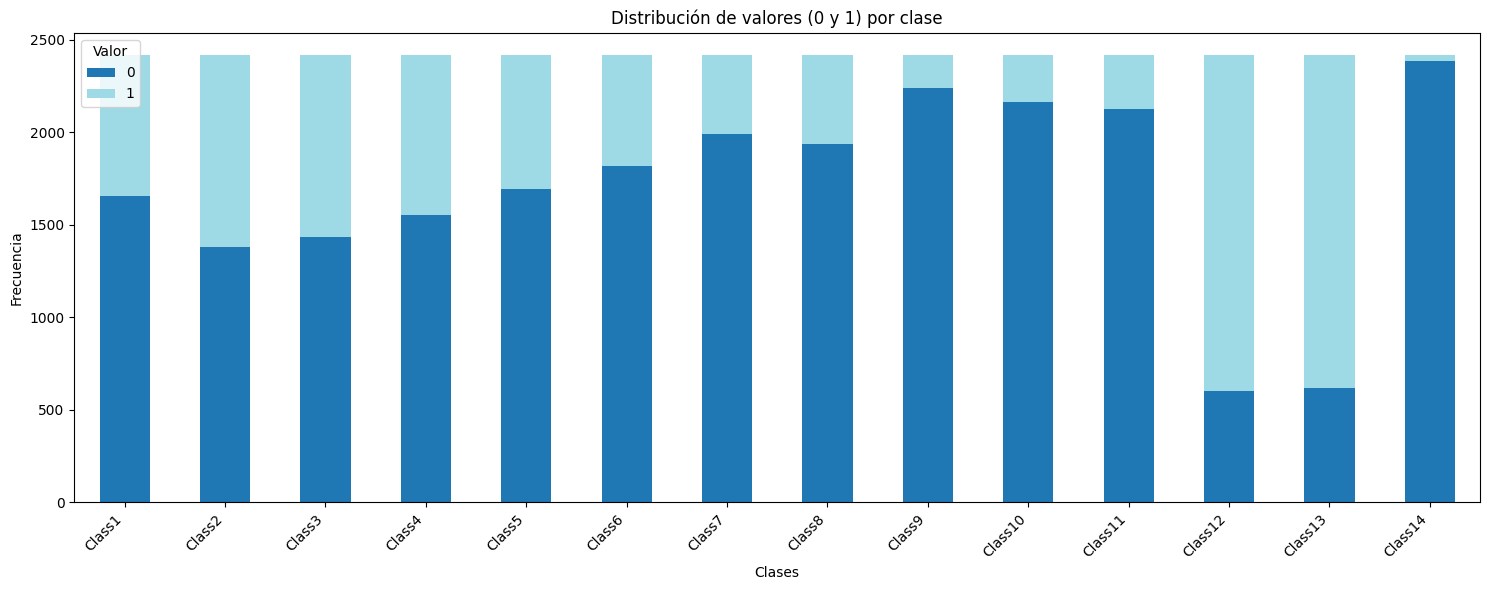

In [8]:
# Calcular counts por clase (0 y 1)
counts = proteinas[cols_clase].apply(lambda col: col.value_counts())

# # Asegurar que existen columnas 0 y 1 aunque alguna clase tenga solo un valor
counts = counts.reindex([0,1]).T.fillna(0)

# Plot apilado
plt.figure(figsize=(15, 6))
counts.plot(kind='bar', stacked=True, figsize=(15,6), colormap='tab20')

plt.title("Distribución de valores (0 y 1) por clase")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.legend(["0", "1"], title="Valor")
plt.tight_layout()
plt.show()

Visualmente podemos ver claramente que las clases más desbalanceadas son la **clase 14**, la **clase 9**, la **clase 10** y la **clase 11**. Por otra parte, las **clases 2, 3 y 4** son las que menos desbalanceo muestran, tal y como habíamos indicado antes.

## Tratamiento de outliers y normalización <a class="anchor" id="outliers"></a>

Pasamos ahora a ver cómo están distribuidos nuestros datos.

In [9]:
proteinas.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,Att19,Att20,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,Att38,Att39,Att40,Att41,Att42,Att43,Att44,Att45,Att46,Att47,Att48,Att49,Att50,Att51,Att52,Att53,Att54,Att55,Att56,Att57,Att58,Att59,Att60,Att61,Att62,Att63,Att64,Att65,Att66,Att67,Att68,Att69,Att70,Att71,Att72,Att73,Att74,Att75,Att76,Att77,Att78,Att79,Att80,Att81,Att82,Att83,Att84,Att85,Att86,Att87,Att88,Att89,Att90,Att91,Att92,Att93,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,0.000514,0.000015,0.001003,0.001034,0.001663,0.000541,0.001372,0.000079,0.000081,0.000741,0.000687,0.001252,0.001529,0.001659,0.001595,0.001606,0.001522,0.001263,0.001120,0.000981,0.001068,0.000264,0.000446,0.000433,0.001119,0.001018,0.001360,0.000922,0.000534,0.000488,0.000379,0.000590,0.000589,-0.000647,-0.000186,-0.000265,0.000002,0.000801,-0.001140,-0.000873,-0.001347,-0.001415,-0.000833,0.000047,-0.000945,0.000009,-0.001249,-0.001182,-0.000681,-0.001085,-0.002032,-0.001614,-0.001148,-0.001134,0.001384,0.000588,0.000348,-0.000382,0.000527,-0.001209,-0.000373,-0.000579,0.001819,0.000206,0.000040,0.000464,0.000822,-0.001212,-0.001635,0.000897,0.000052,-0.001972,-0.001387,-0.002414,-0.001199,-0.000974,-0.000907,-0.001480,-0.001438,-0.001692,-0.001773,-0.001085,-0.000648,-0.000773,0.000464,-0.000515,0.000667,0.000324,-0.001483,-0.001047,-0.001539,0.000284,0.007605
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,0.097279,0.096656,0.097592,0.098400,0.097155,0.097336,0.098293,0.096863,0.100179,0.098147,0.099362,0.100441,0.101464,0.100548,0.099860,0.099084,0.097744,0.098491,0.098639,0.097996,0.097963,0.097889,0.099998,0.098882,0.098082,0.097925,0.098805,0.098891,0.098190,0.099247,0.098683,0.099282,0.098567,0.099448,0.099031,0.097636,0.098602,0.098269,0.103662,0.105722,0.105738,0.105496,0.105018,0.102514,0.101613,0.103905,0.105342,0.105363,0.096055,0.101302,0.102951,0.101432,0.099600,0.100196,0.099374,0.099386,0.099243,0.099325,0.098734,0.098410,0.100300,0.101562,0.098635,0.098229,0.099002,0.099179,0.098721,0.101280,0.102148,0.096262,0.096202,0.094657,0.094645,0.096449,0.092333,0.093365,0.095102,0.096868,0.094832,0.095411,0.095564,0.093853,0.095656,0.093316,0.096684,0.096209,0.096635,0.096280,0.094369,0.096900,0.094211,0.093154,0.099368
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,-0.292335,-0.369496,-0.537280,-0.392255,-0.394669,-0.347946,-0.588576,-0.354161,-0.264644,-0.297746,-0.592886,-0.342229,-0.313491,-0.3

A simple vista parece que todos nuestros datos están centrados en 0 (media cercana a 0) y con valores entre 1 y -1. Por tanto, al estar todas las variables dentro del mismo rango de valores y tener la misma escala, `no es necesario normalizarlas`. Pasamos a ver gráficamente las distribuciones graficando los boxplots de las variables predictoras. Comprobaremos también si hay valores atípicos. Mostramos los boxplots de las variables en conjuntos de 10 para facilitar la legibilidad.

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


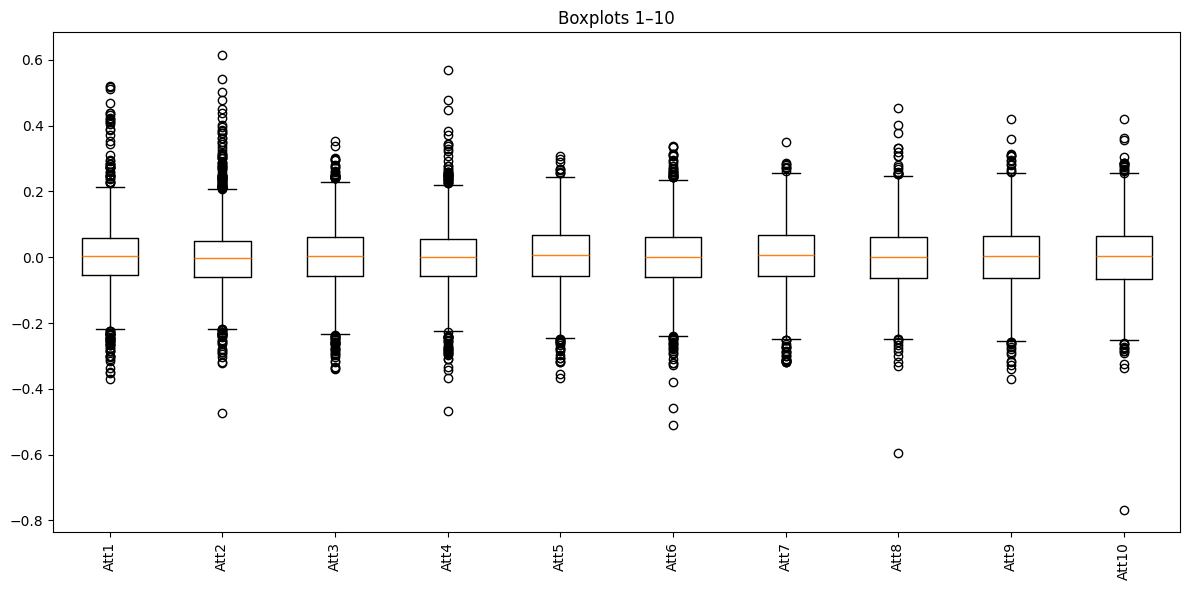

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


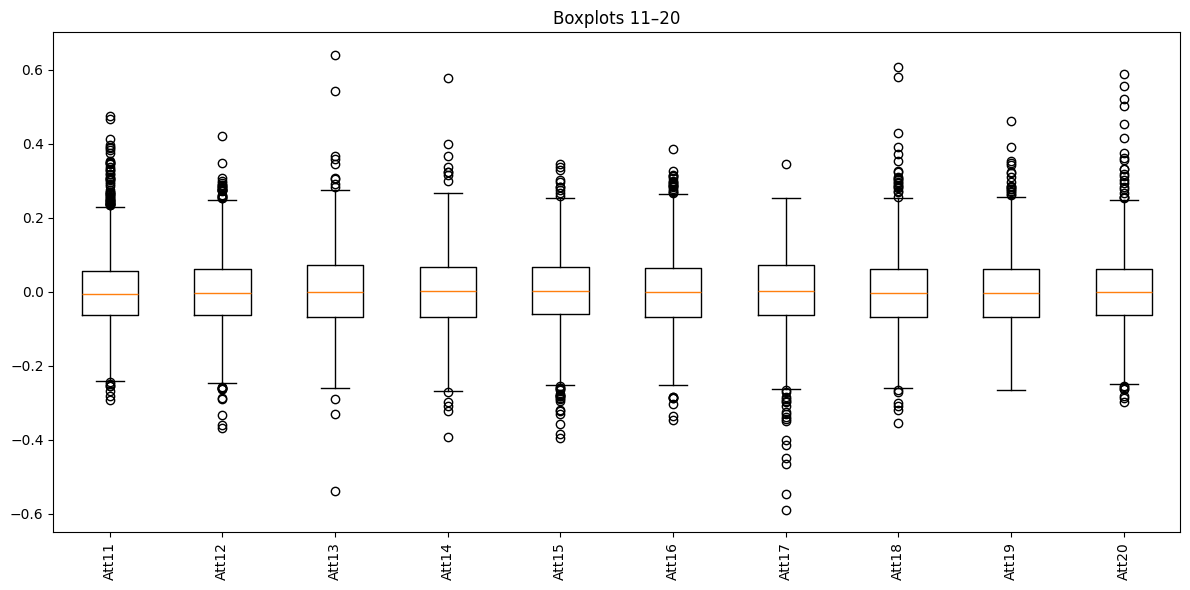

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


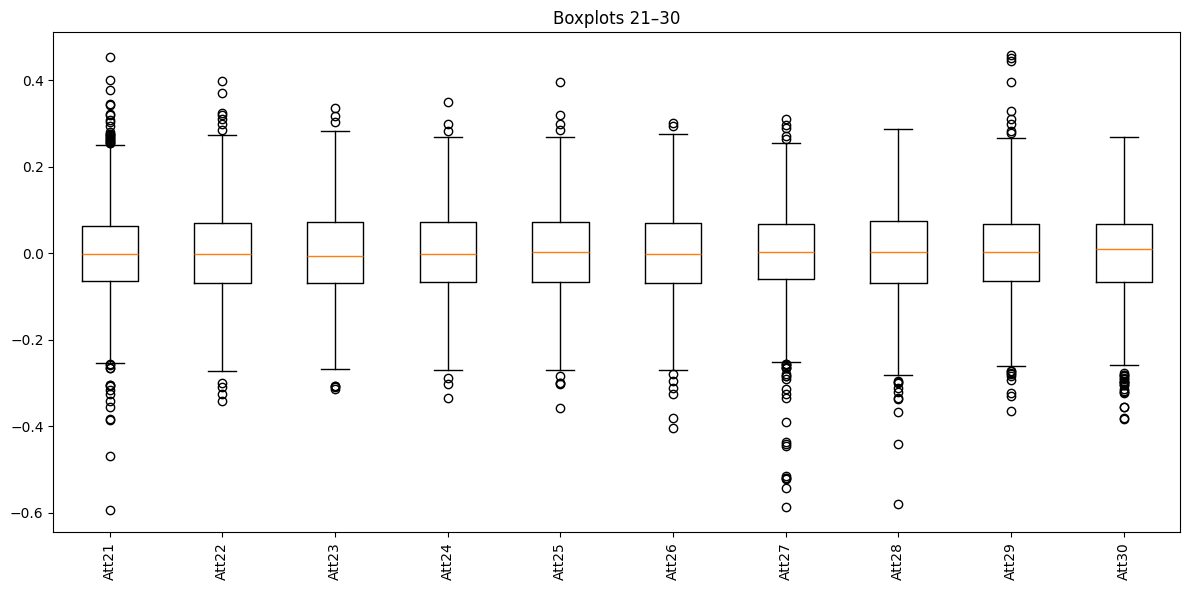

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


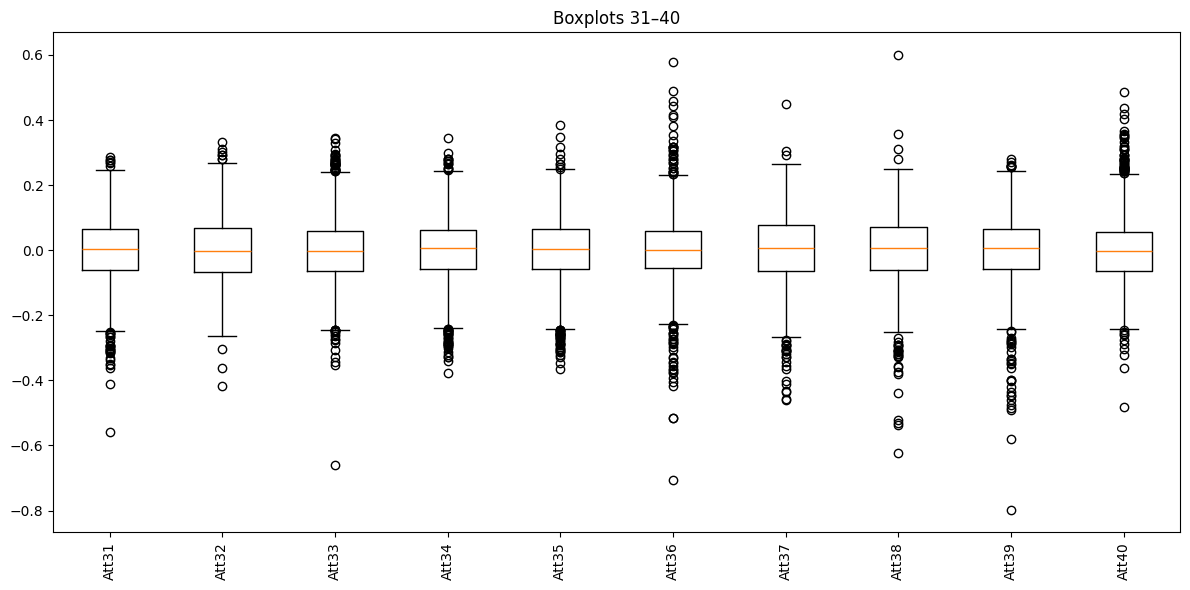

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


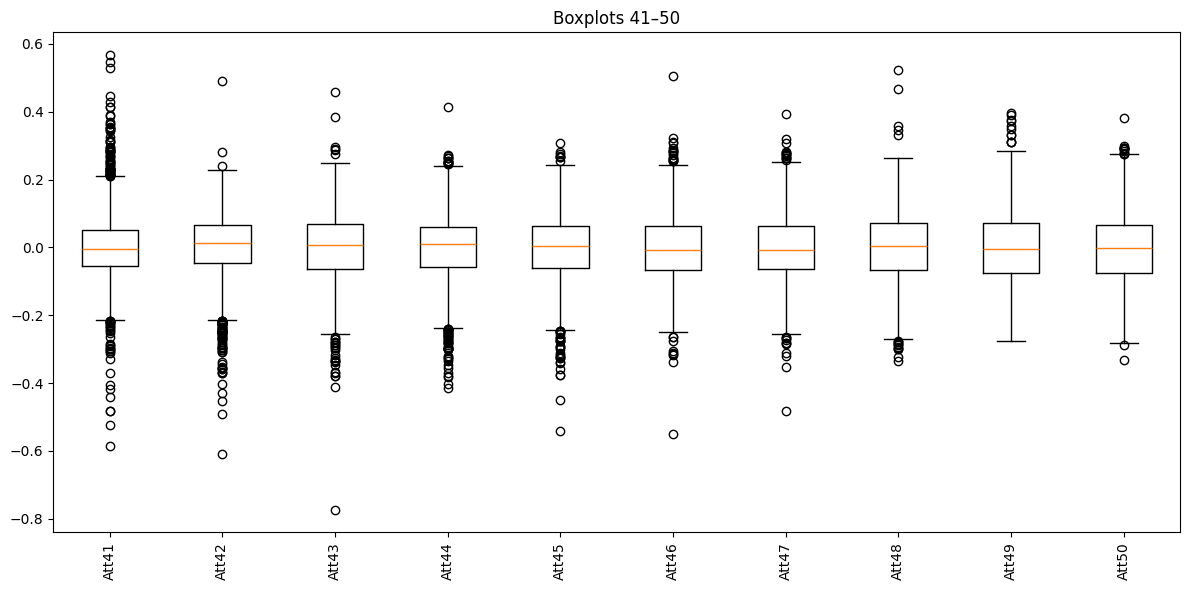

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


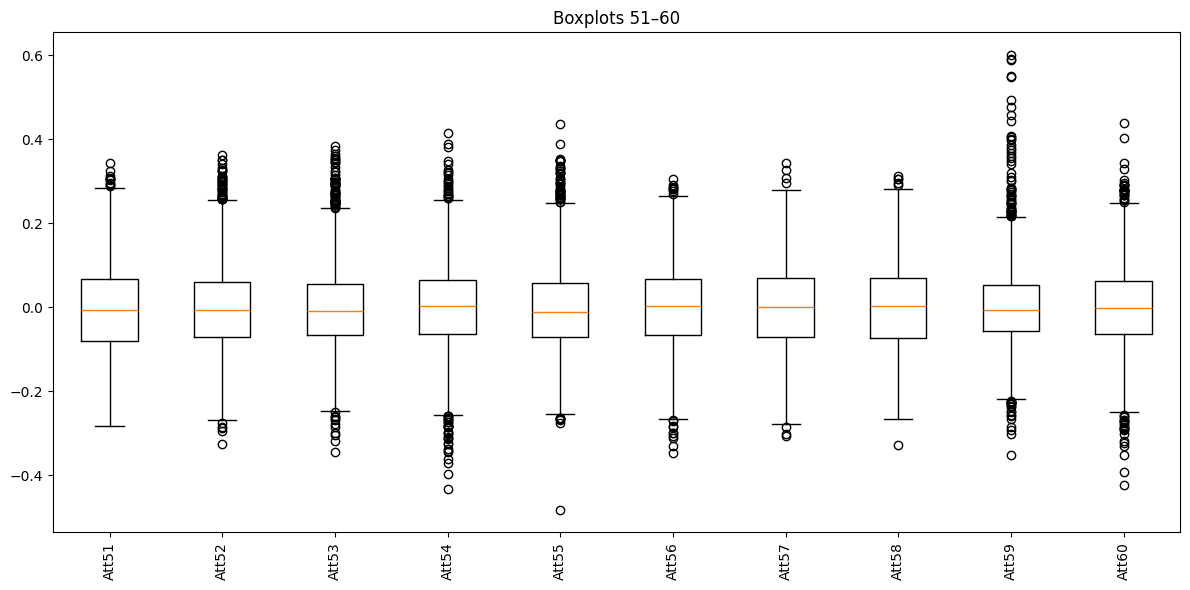

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


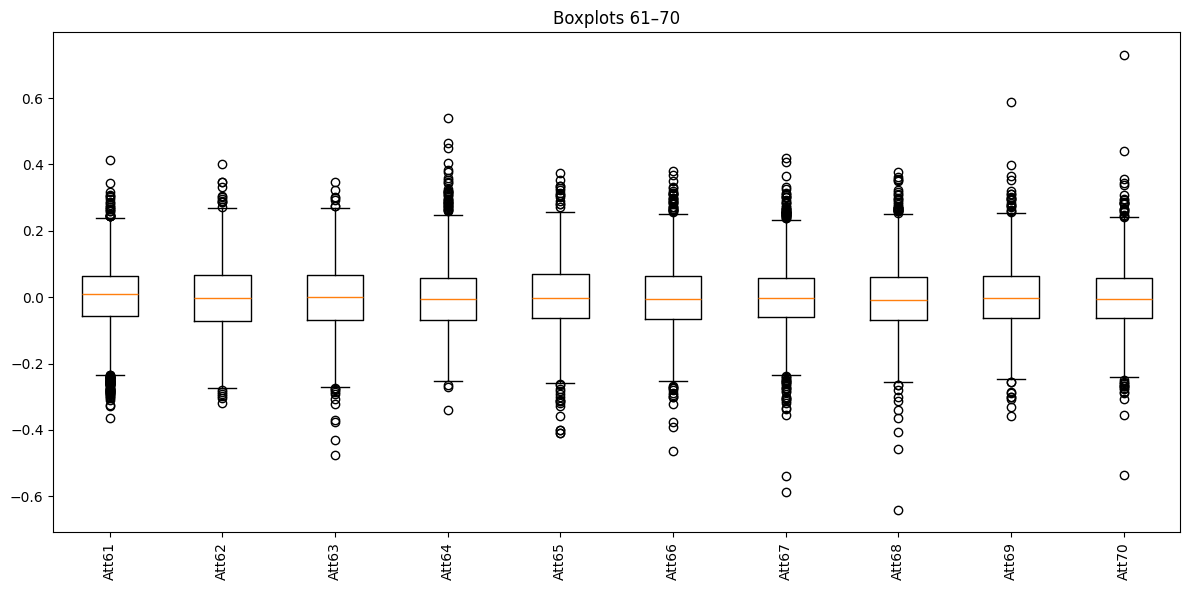

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


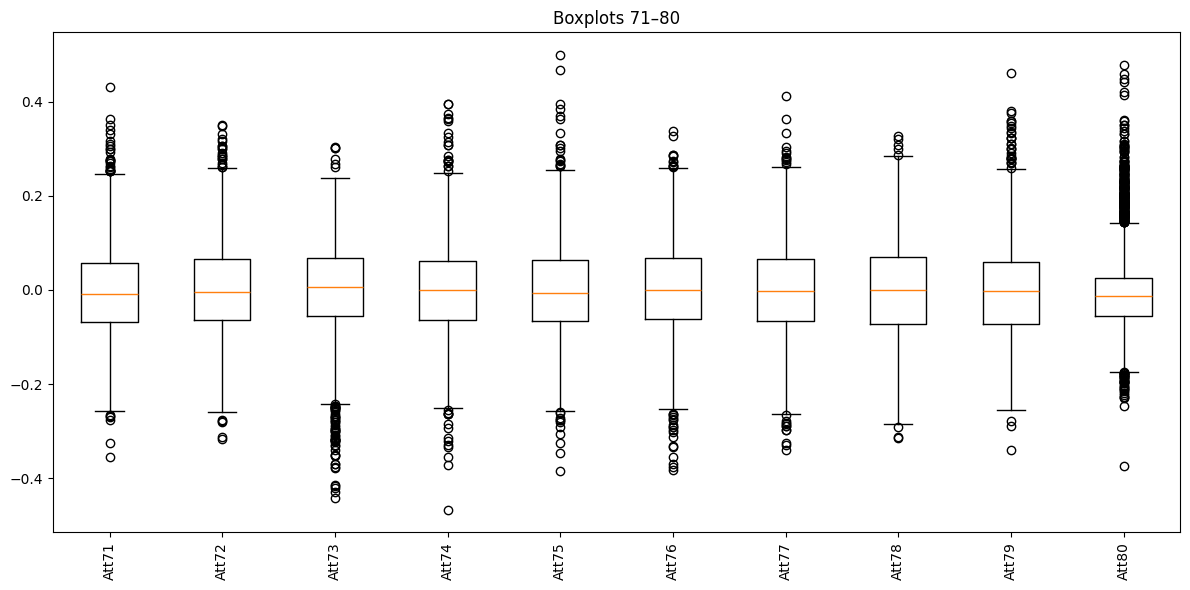

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


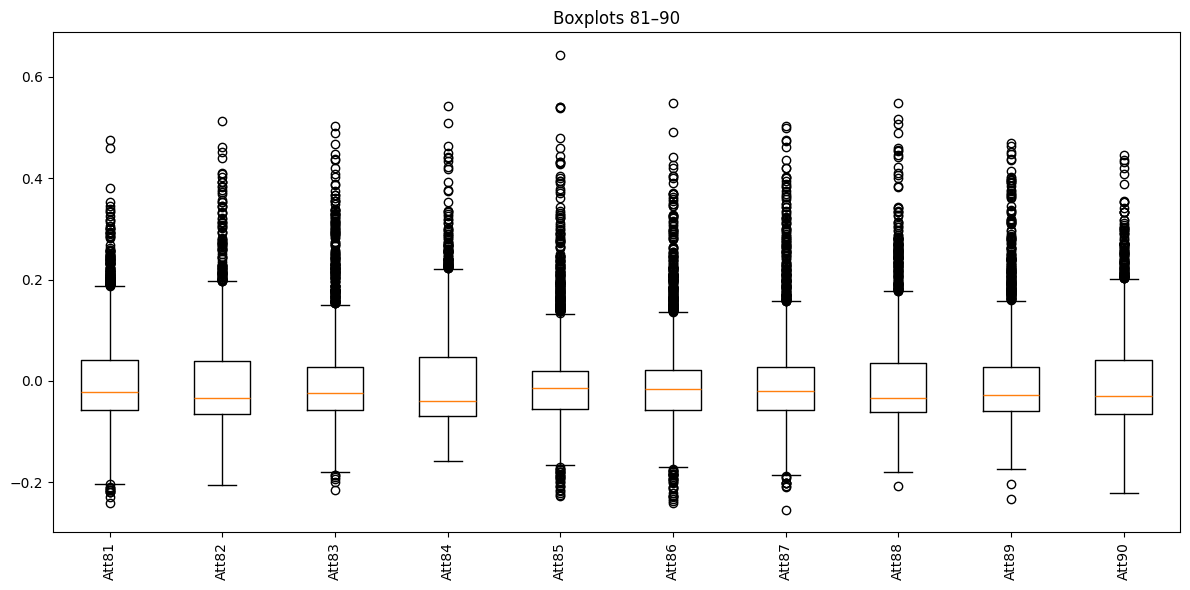

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


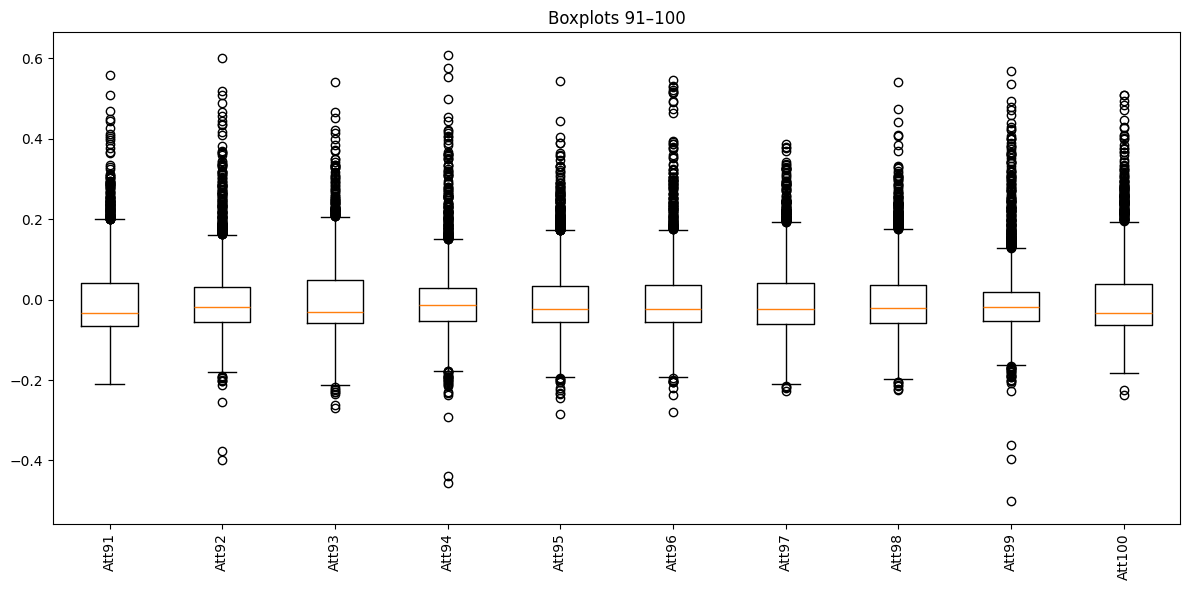

C:\Users\vecto\AppData\Local\Temp\ipykernel_43824\3319044151.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)


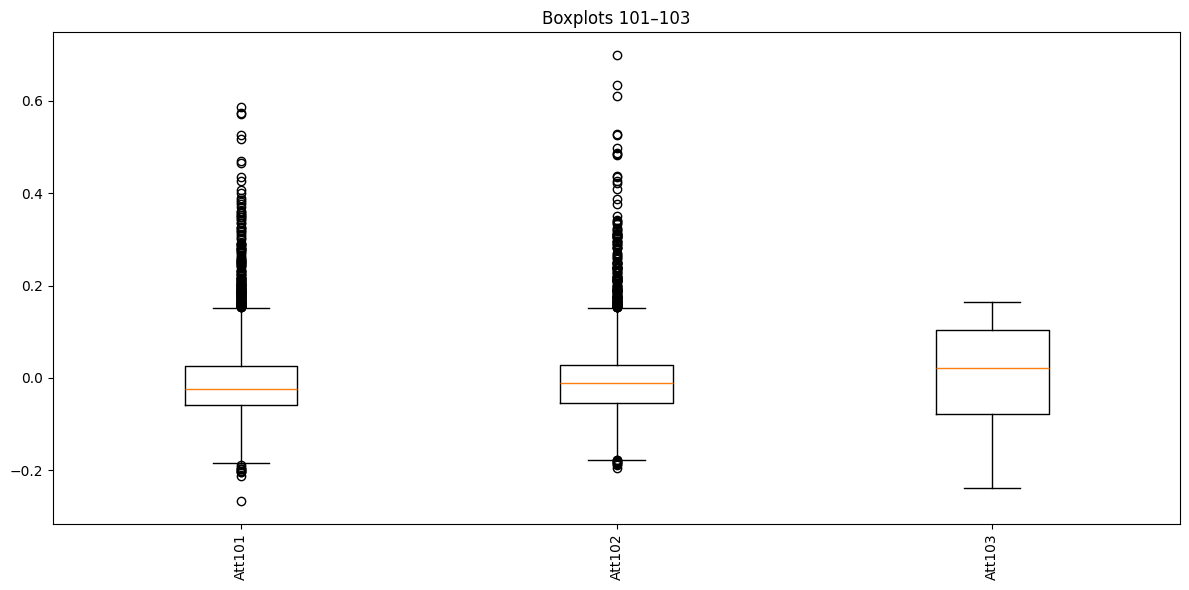

In [10]:
# Boxplots de las variables predictoras (las primeras 103 columnas)
# Consultado a chatGPT
predictoras = proteinas.columns[:103]
#Mostramos los boxplots de las variables de 10 en 10 para que sea más legible
batch = 10
total = len(predictoras)
num_figs = math.ceil(total / batch)
# Mostramos todas los boxplots
for i in range(num_figs):
    subset = predictoras[i*batch : (i+1)*batch]
    plt.figure(figsize=(12, 6))
    plt.boxplot([proteinas[col].dropna() for col in subset], labels=subset)
    plt.xticks(rotation=90)
    plt.title(f'Boxplots {i*batch + 1}–{min((i+1)*batch, total)}')
    plt.tight_layout()
    plt.show()

Vemos que para cada columna de valores de las proteínas recogidas, es decir, para cada variable predictora, existe una gran cantidad de datos atípicos (con la única excepción de la variable 103). Esto puede deberse a que, por la fórmula que se está utilizando para calcular cuándo un dato es un *outlier*, se establece que muchos datos son atípicos por tener la gran mayoría de ellos una media cercana a cero y una desviación típica muy pequeña. Cualquier dato fuera de este pequeño rango establecido, es considerado atípico. Sin embargo, en este tipo de problemas médicos, pueden ser los datos atípicos los que estén recogiendo información y comportamiento irregulares de las proteínas. Los procesos biológicos moleculares tienen un funcionamiento muy complejo y aquí estamos buscando clasificar y predecir enfermedades, por lo que debemos estar atentos a medidas atípicas de las proteínas. Por tanto, es que posible que los *outliers* sean los que más información nos aporten.

Por estas razones, de momento decidiremos **no eliminar ni imputar ninguno de nuestros *outliers***, puesto que pueden ser estos los que sean clave para determinar qué enfermedades están presentes en cada una de nuestras muestras. 

# Entrenamiento de modelo baseline <a class="anchor" id="linea-base"></a>

Primero, decidimos entrenar un primer método sin preprocesar nuestros datos para usarlo como referencia de medida a mejorar por los siguientes modelos que se desarrollen después. Usaremos un método rápido de entrenar como K-vecinos. Además, utilizaremos los valores por defecto puesto que en este primer modelo baseline aún no haremos optimización de hiperparámetros. No tendremos tampoco en cuenta el desbalanceo de los datos en esta primera instancia.

In [11]:
#Separamos las variables predictoras de las de clase
protX = proteinas.drop(cols_clase, axis=1)
protY = proteinas[cols_clase]

Dividimos el dataset en conjunto de entrenamiento y test (80% - 20%). Como ya hemos comentado, en este primer modelo baseline no haremos estratificación en un principio por no tener en cuenta el desbalanceo.

In [12]:
from sklearn.model_selection import train_test_split

# Dividimos el dataset en conjunto de entrenamiento y conjunto de prueba (80% - 20%)
X_train, X_test, Y_train, Y_test=train_test_split(protX, protY, train_size=0.8, random_state=semilla)
print(len(X_train))
print(len(X_test))


1933
484


Vemos que se ha separado el dataset correctamente, dando lugar a 1933 ejemplos para train y 484 para test. Entrenamos nuestro clasificador de K-vecinos tras dividir el dataset.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Elegimos este valor para probar por primera vez el modelo
n_neighbors = 5
# Construimos y entrenamos nuestro modelo 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, Y_train)

#Observamos la métrica de accuracy para el modelo
print("SCORE - Accuracy hard:",knn.score(X_test, Y_test))

predichos = knn.predict(X_test)


SCORE - Accuracy hard: 0.20454545454545456


Obtenemos una score bastante baja para los casos de test. Esto se debe a que estamos usando una medida de evaluación hard, en concreto **accuracy** (o exactitud). En este caso, sólo estamos considerando un acierto cuando el modelo consigue predecir correctamente todas las clases para cada instancia. Es decir, contamos un acierto cuando para un ejemplo predecimos bien todas las clases presentes y no presentes (todos los 1s y todos los 0s). Por tanto, no estamos reflejando fielmente cómo de bien está acertando el clasificador. Para obtener una medida que refleje algo mejor el funcionamiento del modelo, usamos una métrica soft como la pérdida de Hamming. En este caso, buscamos puntuacion cercanas a cero.

In [14]:

print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))

Hamming Loss:  0.205


Vemos que, usando la pérdida de Hamming, obtenemos unas medidas buenas para el clasificador multietiqueta. Lo que hace la pérdida de Hamming es medir el porcentaje de etiquetas incorrectas dentro del total de todas ellas. Por ello, buscamos que el valor se acerque lo máximo posible a cero. Esto quiere decir que, a pesar de que el clasificador no suele acertar todas las clases de una misma correctamente, es capaz de acertar bastantes en términos generales. Comprobamos esto mismo viendo las matrices de confusión de las clases.

In [15]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

cm_all = multilabel_confusion_matrix(Y_test, predichos)
print(cm_all)



[[[300  36]
  [ 85  63]]

 [[192  76]
  [107 109]]

 [[217  61]
  [ 78 128]]

 [[240  65]
  [ 61 118]]

 [[289  46]
  [ 57  92]]

 [[348  29]
  [ 78  29]]

 [[387  15]
  [ 63  19]]

 [[357  24]
  [ 82  21]]

 [[441   0]
  [ 43   0]]

 [[435   6]
  [ 40   3]]

 [[434   7]
  [ 40   3]]

 [[ 14  95]
  [ 49 326]]

 [[ 17  94]
  [ 49 324]]

 [[479   0]
  [  5   0]]]


Si observamos las diagonales de las matrices de confusión vemos que, efectivamente, para cada una de las clases estamos acertando entre un 60% y un 80% de ejemplos. En algunos casos como las **clases 7, 9, 10, 11 y 14**  incluso acertamos más de un 80%. Podemos observar también que, precisamente en estas últimas 4 clases mencionadas, obtenemos muchos verdaderos positivos y pocos verdaderos negativos. Esto se debe a que son estas las clases más desbalanceadas del dataset y por tanto, el clasificador no es capaz de aprender correctamente los casos negativos, que son los más escasos.


# Estrategias de validación y evaluación <a class="anchor" id="evaluacion"></a>

Vemos ahora otras medidas sobre cada una de estas que pueden sernos más útiles que la *accuracy*.

In [16]:
for i in Y_test.columns:
    print(f'Clase: {i}')
    print(metrics.classification_report(Y_test[i], predichos[:, Y_test.columns.get_loc(i)]))

Clase: Class1
              precision    recall  f1-score   support

       False       0.78      0.89      0.83       336
        True       0.64      0.43      0.51       148

    accuracy                           0.75       484
   macro avg       0.71      0.66      0.67       484
weighted avg       0.74      0.75      0.73       484

Clase: Class2
              precision    recall  f1-score   support

       False       0.64      0.72      0.68       268
        True       0.59      0.50      0.54       216

    accuracy                           0.62       484
   macro avg       0.62      0.61      0.61       484
weighted avg       0.62      0.62      0.62       484

Clase: Class3
              precision    recall  f1-score   support

       False       0.74      0.78      0.76       278
        True       0.68      0.62      0.65       206

    accuracy                           0.71       484
   macro avg       0.71      0.70      0.70       484
weighted avg       0.71      0.7

f:\UMU\Master IA\ML\practica1\.ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\UMU\Master IA\ML\practica1\.ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\UMU\Master IA\ML\practica1\.ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f

La precisión nos indica cómo de bien hemos acertado entre nuestras predicciones para un caso positivo, es decir, de los ejemplos medidos como verdaderos para una clase, cuántos de ellos realmente lo eran. La sensibilidad (*recall*), otra parte, nos dice cuántos positivos hemos acertado de entre todos los reales.Podemos Esta última será la que más nos interese de entre las dos, puesto que en un problema médico como este, lo que más queremos evitar son los falsos negativos. Podemos ver en las métricas anteriores que, salvo en las clases más desbalanceadas, tenemos unas medidas que suelen estar por encima del 50% en precisión y sensibilidad de positivos.

Por otra parte, la f1-score es una métrica que agrega estas dos medidas a la hora de ser calculada. Por tanto, la f1-score puede ser nuestra medida más útil para ver realmente cómo de bien estamos clasificando los ejemplos de test. A partir de este momento, para cada modelo calcularemos también la f1-score micro y macro (además de la *accuracy* y la pérdida de Hamming). Estaremos especialmente atentos a la f1-micro, puesto que esta tiene en cuenta el desbalanceo de las clases ponderándolas, penalizando aquellas clases que son menos comunes en el dataset.

Resumiendo, `estas serán las medidas a las que estaremos atentos`.

In [17]:
#Medimos métricas
print("SCORE - Accuracy hard:",knn.score(X_test, Y_test))
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.20454545454545456
Hamming Loss:  0.205
F1-micro : 0.64
F1-macro : 0.416


Tenemos una *accuracy* del 20.45%, una pérdida de Hamming de 0.205, una F1-micro de 0.64 y una F1-macro de 0.416.

Vemos ahora que tal se comporta este primer clasificador baseline si dividimos los datos teniendo en cuenta el desbalanceo. Por tanto, usaremos estratificación para dividir nuestros datos. Lo haremos de nuevo en un porcentaje 80% para train y 20% para test.

In [18]:
from skmultilearn.model_selection import IterativeStratification
#Estratificamos en 2 en ratio 80/20
stratifier = IterativeStratification(
    n_splits=2,
    order=1,
    sample_distribution_per_fold=[0.8, 0.2],   # train 80%, test 20%
)

#Por algún motivo, devuelve primero los índices de test y luego los de train, así que los invertimos
test_idx, train_idx = next(stratifier.split(protX, protY))
# Sacamos nuestros conjuntos de train y test
X_train, X_test = protX.iloc[train_idx], protX.iloc[test_idx]
Y_train, Y_test = protY.iloc[train_idx], protY.iloc[test_idx]



Comprobamos cómo los ha dividido.

In [19]:
X_train.shape



(1926, 103)

Ahora tenemos un conjunto de 1926 ejemplos para train.

In [20]:
X_test.shape

(491, 103)

Tenemos un conjunto de 491 ejemplos para train. Han cambiado ligeramente los conjuntos en unos pocos ejemplos. Observamos el desbalanceo actual.

In [21]:
showBalanceoClases(Y_train)

Clase: Class1 
True:  610 (31.67%)
False: 1316 (68.33%)

Clase: Class2 
True:  830 (43.09%)
False: 1096 (56.91%)

Clase: Class3 
True:  786 (40.81%)
False: 1140 (59.19%)

Clase: Class4 
True:  688 (35.72%)
False: 1238 (64.28%)

Clase: Class5 
True:  563 (29.23%)
False: 1363 (70.77%)

Clase: Class6 
True:  475 (24.66%)
False: 1451 (75.34%)

Clase: Class7 
True:  342 (17.76%)
False: 1584 (82.24%)

Clase: Class8 
True:  384 (19.94%)
False: 1542 (80.06%)

Clase: Class9 
True:  132 (6.85%)
False: 1794 (93.15%)

Clase: Class10 
True:  202 (10.49%)
False: 1724 (89.51%)

Clase: Class11 
True:  241 (12.51%)
False: 1685 (87.49%)

Clase: Class12 
True:  1453 (75.44%)
False: 473 (24.56%)

Clase: Class13 
True:  1439 (74.71%)
False: 487 (25.29%)

Clase: Class14 
True:  27 (1.40%)
False: 1899 (98.60%)



No parece que haya cambiado demasiado el desbalanceo de las clases. El método ***IterativeStratification*** intenta construir conjuntos balanceados en la medida de lo posible. Este se trata de un ejemplo difícil de balancear con este método puesto que tenemos muchas clases y cada instancia pertenece a varias de ellas. Sin embargo, a partir de ahora `usaremos la división estratificada del dataset` puesto que pensamos que se trata de la manera más correcta de proceder en este tipo de problemas tan desbalanceados.

Volvemos a entrenar el modelo baseline.

In [22]:
knn.fit(X_train, Y_train)
print("SCORE - Accuracy hard:",knn.score(X_test, Y_test))

predichos = knn.predict(X_test)

SCORE - Accuracy hard: 0.20570264765784113


In [23]:
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

Hamming Loss:  0.206
F1-micro : 0.637
F1-macro : 0.414


Vemos que para la medida de *accuracy* tenemos un dato muy ligeramente superior: 20.57%. Sin embargo, esto puede ser puro azar. También vemos que el modelo, tras dividir con el método *IterativeStratification*, nos devuelve peores resultados para todas las métricas de pérdida de Hamming (0.206) y F1-micro (0.637). `Estas serán las medidas del método baseline que tomaremos como ejemplo a comparar con las del resto de modelos.`

# Entrenamiento de modelos más robustos <a class="anchor" id="entrenamiento"></a>

A continuación, procederemos a entrenar modelos más robustos para ver si nos permiten realizar una mejor clasificación multietiqueta. Usaremos primero un sólo valor para los parámetros de cada uno. Más adelante haremos ajuste de hiperparámetros para intentar conseguir la mejor versión de cada uno.

Los modelos seleccionados son:

* Clasificador Extra-trees
* Clasificador XGBoost
* Clasificador MLP

Escogemos estos para poder tener varios modelos con distintos grados de interpretabilidad y de eficiencia computacional, siendo Extra-trees el más interpretable y eficiente, y el MLP el más complejo y más pesado de calcular.

## Extra-trees <a class="anchor" id="trees"></a>

Ahora entrenaremos un modelo de extra-trees. Usaremos la división del dataset estratificado.

In [24]:
from sklearn.ensemble import ExtraTreesClassifier
# Construimos el modelo con valores por defecto
extraTrees = ExtraTreesClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, min_samples_split=2, random_state=semilla)
#Entrenamos el modelo
extraTrees.fit(X_train, Y_train)

#Vemos las métricas
print("SCORE - Accuracy hard:",extraTrees.score(X_test, Y_test))
# Obtenemos las predicciones
predichos = extraTrees.predict(X_test)
# Medimos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.1446028513238289
Hamming Loss:  0.198
F1-micro : 0.613
F1-macro : 0.323


Con los parámetros por defecto, obtenemos peores resultados en general. `Tenemos una accuracy del 14.46%, una pérdida de Hamming de 0.198 y una F1-micro de 0.613.`

## XGBoost <a class="anchor" id="xgboost"></a>

Ahora probaremos nuestro modelo de XGBoost. Utilizamos el dataset dividido con estratificación.



In [25]:
# Creamos nuestro modelo XGBoost
xgboost = MultiOutputClassifier(XGBClassifier(eta=0.3,max_depth=6, min_child_weight=1,max_leaves=0,n_estimators=100,random_state=semilla,nthread=2))
#Entrenamos el modelo
xgboost.fit(X_train, Y_train)
#Vemos la score
print("SCORE - Accuracy hard:",xgboost.score(X_test, Y_test))
#Obtenemos las predicciones
predichos = xgboost.predict(X_test)
#Medimos las otras métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.15885947046843177
Hamming Loss:  0.195
F1-micro : 0.645
F1-macro : 0.403


Vemos que con estos parámetros ya obtenemos mejores medidas que el modelo baseline si no tenemos en cuenta la exactitud. `Tenemos una accuracy del 15.89%, una pérdida de Hamming de 0.195 y una F1-micro de 0.645`

## MLP <a class="anchor" id="mlp"></a>

Por último entrenaremos un MLP con dos capas. 

In [26]:
# Utilizamos un MLP como salida multietiqueta
from sklearn.neural_network import MLPClassifier
#Construimos nuestro modelo con valores predeterminados
mlp = MLPClassifier(hidden_layer_sizes=(100,100),learning_rate='constant', learning_rate_init=0.001, max_iter=300,early_stopping=True, random_state=semilla)
# Entrenamos el modelo
mlp.fit(X_train, Y_train)
#Vemos las métricas
print("SCORE - Accuracy hard:",mlp.score(X_test, Y_test))
#Obtenemos predicciones
predichos = mlp.predict(X_test)
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.1710794297352342
Hamming Loss:  0.192
F1-micro : 0.653
F1-macro : 0.381


Con el MLP con parámetros por defecto, obtenemos el mejor modelo de entre los 3 con una ` accuracy del 17.11%, una pérdida de Hamming de 0.192 y una F1-micro de 0.653`. Aún obtenemos resultados ligeramente inferiores en *accuracy* si lo comparamos con el modelo baseline, pero como hemos señalado antes, esto no nos importa tanto puesto que esta medida no está reflejando bien el conjunto global de aciertos de nuestro clasificador. 

Intentaremos mejorar los resultados de estos modelos realizando un mayor preprocesado sobre los datos.

# Extracción de características <a class="anchor" id="caracteristicas"></a>

Vamos a intentar obtener un mejor resultado haciendo un mejor preprocesado de los datos.


Lo siguiente que vamos a hacer es probar a hacer extracción de características sobre el dataset de entrada. Haremos extracción en vez de selección de características porque, al final, tenemos un problema con variables que representan valores tomados sobre cierta medida acerca de una proteína. Los procesos biológicos moleculares presentan funcionamientos muy complejos y no nos atrevemos a eliminar columnas directamente del dataset porque cada una de ellas puede estar capturando información subyacente que podría ser relevante al problema. Cada una ellas podría tener importancia en relación con las demás a la hora de predecir y clasificar enfermedades. Además, las variables son de difícil interpretabilidad tanto en conjunto como de manera individual. Tampoco nos atrevemos a filtrarlas usando métodos como *Recursive Feature Elimination* puesto que podríamos estar librándonos de información importante.

Es muy común en problemas médicos de este estilo usar técnicas de reducción de dimensionalidad (como PCA) en vez de filtrar variables y eliminarlas. Comprobaremos si conseguimos quedarnos con un espacio de dimensiones más reducido y que contenga la información más relevante para nuestro problema.Por ello, aplicaremos un PCA sobre las variables de nuestro dataset.

Buscamos obtener el número de componentes principales que sea capaz de explicar el 90% de la varianza de los datos. Lo hacemos a partir del dataset original.

In [27]:
from sklearn.decomposition import PCA
#Aplicamos PCA para reducción de dimensionalidad
# Buscamos el número de componentes principales que expliquen el 90% de la varianza
pca = PCA(n_components=0.9)
# Transformamos usando las componentes principales
X_pca = pca.fit_transform(protX)

print("Número de componentes seleccionadas:", pca.n_components_)
print(pca.explained_variance_ratio_)

Número de componentes seleccionadas: 59
[0.11037397 0.06918929 0.06601565 0.05275227 0.04264664 0.03767063
 0.03380919 0.02863342 0.02643698 0.02384569 0.02213274 0.02083947
 0.01833496 0.01633096 0.01608713 0.01463353 0.01345928 0.01282345
 0.01227977 0.01166308 0.01105348 0.01049984 0.00985546 0.00972897
 0.00937598 0.00889791 0.00867513 0.00842809 0.00816844 0.00774485
 0.00766588 0.00740167 0.00724836 0.00710927 0.00694474 0.00673161
 0.00653904 0.00637469 0.00616054 0.00596894 0.00588712 0.00575817
 0.00552989 0.00543526 0.00524102 0.00501056 0.00497425 0.00488598
 0.00479798 0.0047336  0.00458933 0.00452746 0.00446972 0.00433422
 0.00415801 0.00410247 0.00404707 0.00396501 0.00394737]


Seleccionamos en total 59 componentes. Vemos la varianza explicada por cada una de ellas. En un principio decidimos seleccionar tantas como fuesen capaces de explicar el 95% de varianza, pero obteníamos demasiadas (75) como para realizar una reducción importante de dimensiones. Además, como podemos ver las últimas componentes ya sólo explican un porcentaje muy pequeño de varianza.

Vemos cómo quedan los datos.

In [28]:

X_pca 

array([[ 0.44849207,  0.18452549, -0.15436022, ..., -0.00825378,
         0.03133828,  0.0123469 ],
       [-0.24988029,  0.07854069, -0.18796321, ...,  0.1371045 ,
        -0.03973853, -0.01271454],
       [-0.24125898,  0.12914524,  0.15751337, ..., -0.01552214,
        -0.06213308, -0.02254167],
       ...,
       [-0.20098149,  0.08309512,  0.43646731, ...,  0.03770612,
        -0.03308139,  0.00140112],
       [-0.19068302, -0.18166776, -0.11900361, ...,  0.03721202,
         0.04060695, -0.0358632 ],
       [ 0.06519452,  0.09322536, -0.11415923, ..., -0.00739935,
         0.1290732 ,  0.00761122]], shape=(2417, 59))

Tenemos 2417 filas y 59 columnas. Vemos que hemos realizado correctamente nuestra reducción de dimensionalidad. Pasamos ahora a dividirlos igual que antes, de manera estratificada, y a volver a entrenar los modelos.

In [29]:
# Hacemos la división estratificada
stratifier = IterativeStratification(
    n_splits=2,
    order=1,
    sample_distribution_per_fold=[0.8, 0.2],   # train 80%, test 20%
      
)

#Por algún motivo, devuelve primero los índices de test y luego los de train, así que los invertimos
test_idx, train_idx = next(stratifier.split(X_pca, protY))
# Sacamos de nuevo nuestros conjuntos de train y test
X_train, X_test = X_pca[train_idx], X_pca[test_idx]
Y_train, Y_test = protY.iloc[train_idx], protY.iloc[test_idx]

Vemos la forma de los nuevos datos.

In [30]:
X_train

array([[-0.24125898,  0.12914524,  0.15751337, ..., -0.01552214,
        -0.06213308, -0.02254167],
       [ 0.46528632,  0.13398433, -0.17922749, ...,  0.14171036,
         0.02116746, -0.05156118],
       [ 0.30043938,  0.31116976,  0.05855148, ..., -0.01759692,
        -0.015208  ,  0.06178318],
       ...,
       [-0.20098149,  0.08309512,  0.43646731, ...,  0.03770612,
        -0.03308139,  0.00140112],
       [-0.19068302, -0.18166776, -0.11900361, ...,  0.03721202,
         0.04060695, -0.0358632 ],
       [ 0.06519452,  0.09322536, -0.11415923, ..., -0.00739935,
         0.1290732 ,  0.00761122]], shape=(1924, 59))

Tenemos de nuevo 1924 ejemplos en el conjunto de train.

In [31]:
X_test

array([[ 0.44849207,  0.18452549, -0.15436022, ..., -0.00825378,
         0.03133828,  0.0123469 ],
       [-0.24988029,  0.07854069, -0.18796321, ...,  0.1371045 ,
        -0.03973853, -0.01271454],
       [-0.37596852,  0.3109913 ,  0.25476316, ...,  0.00924554,
        -0.01303281, -0.07619499],
       ...,
       [ 0.43052407, -0.03999691,  0.15343892, ..., -0.01213839,
         0.02849896, -0.05524387],
       [-0.20042011, -0.04197665,  0.09073494, ..., -0.06560789,
        -0.0245047 ,  0.04555078],
       [ 0.30080802,  0.0675228 ,  0.0595711 , ...,  0.04969453,
        -0.00176259,  0.03579649]], shape=(493, 59))

Tenemos de nuevo 493 ejemplos en el conjunto de test.

## Extra-trees  <a class="anchor" id="trees-1"></a>

Entrenaremos el modelo de extra-trees con los datos reducidos con PCA.

In [32]:
#Creamos nuestro modelo con valores por defecto
extraTrees = ExtraTreesClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, min_samples_split=2, random_state=semilla)
#Entrenamos el modelo
extraTrees.fit(X_train, Y_train)
#Vemos las métricas

print("SCORE - Accuracy hard:",extraTrees.score(X_test, Y_test))
# Hacemos las predicciones
predichos = extraTrees.predict(X_test)
# Medimos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.09939148073022312
Hamming Loss:  0.207
F1-micro : 0.579
F1-macro : 0.274


Obtenemos peores resultados con estos datos. Con los datos tras aplicar PCA tenemos `una accuracy del 9.94%, una pérdida de Hamming de 0.207 y una F1-micro de 0.579.`Se trata del peor rendimiento hasta el momento.

## XGBoost <a class="anchor" id="xgboost-1"></a>

Hacemos lo propio con nuestro modelo XGBoost: entrenamos usando los datos transformados con PCA.

In [33]:
# Creamos nuestro modelo XGBoost
xgboost = MultiOutputClassifier(XGBClassifier(eta=0.3,max_depth=6, min_child_weight=1,max_leaves=0,n_estimators=100,random_state=semilla,nthread=2))
#Entrenamos el modelo
xgboost.fit(X_train, Y_train)
#Vemos la score
print("SCORE - Accuracy hard:",xgboost.score(X_test, Y_test))
# Obtenmos las predicciones
predichos = xgboost.predict(X_test)
#Medimos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.12778904665314403
Hamming Loss:  0.208
F1-micro : 0.617
F1-macro : 0.369


Obtenemos medidas algo mejores que con el anterior modelo. Tenemos `una accuracy del 12.78%, una pérdida de Hamming de 0.208 y una F1-micro de 0.617.` Seguimos teniendo peores resultados en comparación con el método de línea base.

## MLP  <a class="anchor" id="mlp"></a>

Entrenamos ahora el MLP con los datos de PCA.

In [34]:
# Creamos nuestro MLP con valores por defecto
mlp = MLPClassifier(hidden_layer_sizes=(100,100),learning_rate='constant', learning_rate_init=0.001, max_iter=300,early_stopping=True, random_state=semilla)
#Entrenamos el modelo
mlp.fit(X_train, Y_train)
# Vemos las métricas
print("SCORE - Accuracy hard:",mlp.score(X_test, Y_test))
# Hacemos las predicciones
predichos = mlp.predict(X_test)
# Medimos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.1744421906693712
Hamming Loss:  0.196
F1-micro : 0.646
F1-macro : 0.374


`Tenemos una accuracy del 17.44%, una pérdida de Hamming de 0.196 y una F1-micro de 0.646 `**El MLP obtiene el mejor resultado de los 3**, mejorando incluso el modelo baseline, pero no estamos consiguiendo mejorar la versión sin reducir dimensiones. Quizás esto se deba a que no hemos realizado la optimización de hiperparámetros o debido al desbalanceo inicial de los datos. Intentaremos corregir esto último.

# Balanceo de datos  <a class="anchor" id="balanceo-2"></a>

Es probable que las mejoras tan marginales que obtenemos con los modelos principales respecto al modelo *baseline* se deban al desbalanceo inicial de las clases. Por tanto, ahora lo que vamos a hacer será un sobremuestreo (*oversampling*) de nuestros datos para intentar solucionar esto. Sin embargo, el *oversampling* en problemas multietiqueta se trata de un problema no trivial. Puesto que cada ejemplo pertenece al mismo tiempo a varias clases, no podemos aplicar técnicas como BorderlineSMOTE o ADASYN de manera individual sobre cada clase, ya que sería artificial crear ejemplos que sólo perteneciesen a una única clase. Además, las nuevas muestras creadas deben tener en cuenta las distribuciones originales entre distintas clases. Por ello, usaremos esta versión de ***MultilabelSMOTE*** definida en https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote.

Aplicaremos la técnica sobre los datos antes de hacer PCA, es decir, sobre el dataset original. Debemos dividir primero los datos antes de hacer el *oversampling*.

In [35]:


# Volvemos a dividir los datos originales sin PCA
stratifier = IterativeStratification(
    n_splits=2,
    order=1,
    sample_distribution_per_fold=[0.8, 0.2],   # train 80%, test 20%
      
)
#Por algún motivo, devuelve primero los índices de test y luego los de train, así que los invertimos
test_idx, train_idx = next(stratifier.split(protX, protY))
# Sacamos de nuevo nuestros conjuntos de train y test
X_train, X_test = protX.iloc[train_idx], protX.iloc[test_idx]
Y_train, Y_test = protY.iloc[train_idx], protY.iloc[test_idx]



Definimos los métodos para hacer el multilabelSMOTE.

In [36]:
# Métodos MultiLabelSMOTE cortesía de https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote
import random
from sklearn.neighbors import NearestNeighbors
#Establecemos semilla para los random 
random.seed(semilla)

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

Estos métodos aumentan los datos usando el algoritmo de MLSMOTE. Este intentará determinar primero las clases menos representadas para luego crear más muestras de ellas.

Creamos 500 ejemplos adicionales para intentar balancear nuestros datos. Elegimos 500 porque supone agregar un 25% de ejemplos sobre el tamaño real. Por supuesto, hacemos el sobremuestreo sólo sobre los datos de entrenamiento.

In [37]:
# Obtenemos las clases menos representadas
X_sub, Y_sub = get_minority_samples(X_train, Y_train)  # Getting minority samples of that datframe
# Creamos 500 ejemplos, 25% aprox de 1924 
X_res, Y_res = MLSMOTE(X_sub, Y_sub, 500, 5)  # Applying MLSMOTE to augment the dataframe



Comprobamos que los datos parezcan correctos.

In [38]:
X_res.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,Att19,Att20,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,Att38,Att39,Att40,Att41,Att42,Att43,Att44,Att45,Att46,Att47,Att48,Att49,Att50,Att51,Att52,Att53,Att54,Att55,Att56,Att57,Att58,Att59,Att60,Att61,Att62,Att63,Att64,Att65,Att66,Att67,Att68,Att69,Att70,Att71,Att72,Att73,Att74,Att75,Att76,Att77,Att78,Att79,Att80,Att81,Att82,Att83,Att84,Att85,Att86,Att87,Att88,Att89,Att90,Att91,Att92,Att93,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.055302,0.002939,0.082769,0.086530,-0.006083,0.014356,-0.094646,-0.086028,-0.008271,-0.146020,0.025229,0.041758,-0.089006,0.001991,-0.005487,0.048760,-0.175971,-0.119782,0.127561,0.036729,0.073624,0.078797,-0.129128,-0.114271,-0.173569,-0.140533,-0.067781,-0.082079,-0.101212,0.069089,-0.020359,0.032862,-0.127582,0.062432,-0.144539,-0.175081,-0.110544,-0.183655,-0.098716,0.105998,-0.063265,-0.150011,-0.144832,-0.021938,-0.260621,-0.065572,-0.247702,-0.040968,0.001150,-0.001503,0.138887,0.155937,0.181590,-0.004125,0.248601,0.171820,-0.003216,-0.041881,-0.060005,0.070701,0.112975,0.114632,0.061105,-0.002426,-0.126066,-0.113634,0.163737,0.191815,-0.079794,-0.141034,0.011249,-0.010598,0.043524,0.160935,-0.021871,0.026297,0.094440,0.110680,0.162390,-0.019910,-0.040404,-0.071221,-0.042568,-0.078172,-0.033622,-0.035886,0.026006,0.060928,0.095958,-0.056577,-0.057937,-0.048141,-0.052206,-0.040251,-0.038880,0.209485,-0.039464,-0.038713,-0.034906,0.112409,-0.040071,-0.003852,0.087317
1,-0.000799,0.167848,0.084578,0.044566,-0.130156,0.202667,-0.113097,-0.116905,-0.042338,0.012910,-0.089478,-0.056129,-0.024960,-0.082528,-0.225913,0.005926,-0.014972,0.060815,0.034035,-0.022345,0.206672,0.072968,0.216528,0.125763,0.139413,-0.168325,-0.206281,-0.132508,0.041898,-0.191141,-0.134594,-0.035862,0.034155,0.125070,0.077357,0.097663,-0.110297,-0.146126,-0.057557,0.028353,0.416470,0.056692,-0.053690,0.059050,-0.020949,-0.114868,0.073018,0.057699,0.096063,-0.018474,-0.069555,0.026683,-0.065054,0.167019,-0.096562,-0.162209,0.044275,0.026752,-0.011450,-0.017785,0.014799,0.016778,-0.187948,0.057122,0.012165,0.110681,0.000015,-0.083127,-0.081890,0.055187,0.006919,0.123101,-0.110809,-0.135224,-0.094975,0.007205,-0.200543,0.060846,-0.089263,-0.008729,-0.027461,-0.047567,-0.015075,-0.057107,-0.000536,-0.011484,-0.020826,-0.013290,-0.033579,-0.044253,-0.039757,-0.027265,-0.046928,0.051180,-0.034525,-0.024611,-0.016699,-0.028035,-0.019419,0.039895,-0.030009,0.316357,0.089142
2,-0.033072,0.501339,-0.091761,-0.049177,-0.015479,-0.025885,0.048230,0.002026,0.124871,-0.122369,-0.080151,-0.015277,-0.754617,0.001773,-0.043705,0.122815,-0.055444,0.083192,-0.175332,-0.028035,0.027535,0.084155,0.057451,-0.023169,-0.037250,-0.127320,0.140318,0.092312,0.030545,0.018751,-0.105642,0.035106,-0.003481,-0.019921,0.050178,0.034410,-0.033299,0.030899,0.008658,-0.055206,-0.665871,0.047953,0.022975,0.149074,-0.037128,-0.003716,-0.032910,0.020384,0.065082,-0.065857,-0.094162,-0.053351,-0.065771,0.134057,-0.135397,-0.043617,0.076529,-0.030548,0.100866,0.032917,0.132033,0.007496,0.103756,-0.109916,-0.039508,0.092304,0.046681,-0.010118,0.232009,0.148248,-0.066309,-0.016023,0.046962,0.005114,0.031616,0.183932,0.062155,0.037101,0.051595,-0.144239,-0.066535,0.093420,0.291602,0.016793,-0.092979,-0.058253,-0.106119,-0.049740,-0.060551,0.039848,0.072723,0.267529,-0.019587,0.005319,-0.083128,-0.098969,-0.207259,-0.146854,0.146859,-0.049366,0.089474,-0.083701,0.091755
3,0.063663,0.168857,0.047536,-0.058263,0.201813,-0.007060,-0.147900,-0.158709,0.000755,0.188256,-0.003593,-0.058670,0.156815,0.015827,0.053278,-0.090754,0.006645,-0.005622,0.176019,-0.087518,0.097039,-0.019614,-0.022597,0.061460,0.006838,0.028821,-0.106916,0.019918,0.147984,-0.069874,0.083007,-0.078665,0.271924,0.271744,0.331253,-0.134605,-0.061680,-0.060946,0.061569,0.035410,0.045928,-0.069515,0.104887,0.013669,0.197060,-0.

El conjunto de variables predictoras tiene valores coherentes. Comprobamos ahora el de etiquetas.

In [39]:
Y_res.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


El conjunto con las etiquetas de clases parece coherente también. Concatenamos las muestras sintéticas a las reales.

In [40]:
# Creamos los nuevos conjuntos balanceados
X_balanced = df_conc = pd.concat([X_train, X_res], axis=0, ignore_index=True)
Y_balanced = df_conc = pd.concat([Y_train, Y_res], axis=0, ignore_index=True)

Comprobamos que tengan el tamaño esperado.

In [41]:
X_balanced.shape

(2429, 103)

Vemos que tiene 2429 ejemplos (1929 reales + 500 sintéticos). Comprobemos el otro dataset.

In [42]:
Y_balanced.shape

(2429, 14)

Coiciden en número de ejemplos: 2429. Comprobamos cómo de balanceados están ahora los datos en nuestro nuevo dataset de entrenamiento. Vemos primero el original.

In [43]:
showBalanceoClases(Y_train)


Clase: Class1 
True:  610 (31.62%)
False: 1319 (68.38%)

Clase: Class2 
True:  830 (43.03%)
False: 1099 (56.97%)

Clase: Class3 
True:  786 (40.75%)
False: 1143 (59.25%)

Clase: Class4 
True:  689 (35.72%)
False: 1240 (64.28%)

Clase: Class5 
True:  564 (29.24%)
False: 1365 (70.76%)

Clase: Class6 
True:  476 (24.68%)
False: 1453 (75.32%)

Clase: Class7 
True:  342 (17.73%)
False: 1587 (82.27%)

Clase: Class8 
True:  384 (19.91%)
False: 1545 (80.09%)

Clase: Class9 
True:  132 (6.84%)
False: 1797 (93.16%)

Clase: Class10 
True:  202 (10.47%)
False: 1727 (89.53%)

Clase: Class11 
True:  241 (12.49%)
False: 1688 (87.51%)

Clase: Class12 
True:  1453 (75.32%)
False: 476 (24.68%)

Clase: Class13 
True:  1439 (74.60%)
False: 490 (25.40%)

Clase: Class14 
True:  27 (1.40%)
False: 1902 (98.60%)



In [44]:
showBalanceoClases(Y_balanced)

Clase: Class1 
True:  936 (38.53%)
False: 1493 (61.47%)

Clase: Class2 
True:  1271 (52.33%)
False: 1158 (47.67%)

Clase: Class3 
True:  1175 (48.37%)
False: 1254 (51.63%)

Clase: Class4 
True:  874 (35.98%)
False: 1555 (64.02%)

Clase: Class5 
True:  1001 (41.21%)
False: 1428 (58.79%)

Clase: Class6 
True:  965 (39.73%)
False: 1464 (60.27%)

Clase: Class7 
True:  771 (31.74%)
False: 1658 (68.26%)

Clase: Class8 
True:  840 (34.58%)
False: 1589 (65.42%)

Clase: Class9 
True:  368 (15.15%)
False: 2061 (84.85%)

Clase: Class10 
True:  503 (20.71%)
False: 1926 (79.29%)

Clase: Class11 
True:  579 (23.84%)
False: 1850 (76.16%)

Clase: Class12 
True:  1953 (80.40%)
False: 476 (19.60%)

Clase: Class13 
True:  1939 (79.83%)
False: 490 (20.17%)

Clase: Class14 
True:  29 (1.19%)
False: 2400 (98.81%)



Parece que hemos mejorado el desbalanceo en las 10 clases menos desbalanceadas. Por otra parte, **las clases 9,10,11 y 14** siguen teniendo un importante desbalanceo. Lo comprabaremos mejor gráficamente.

<Figure size 1500x600 with 0 Axes>

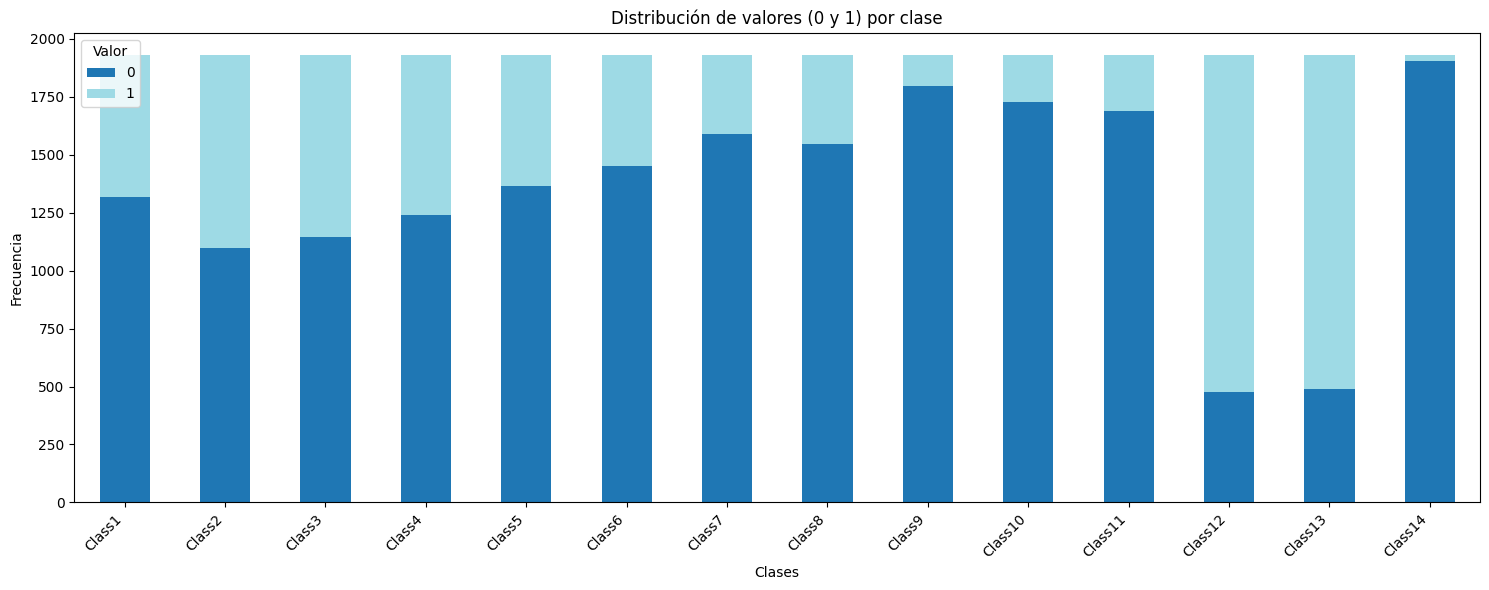

In [45]:
# Calcular counts por clase (0 y 1)
counts = Y_train.apply(lambda col: col.value_counts())

# # Asegurar que existen columnas 0 y 1 aunque alguna clase tenga solo un valor
counts = counts.reindex([0,1]).T.fillna(0)

# Plot apilado
plt.figure(figsize=(15, 6))
counts.plot(kind='bar', stacked=True, figsize=(15,6), colormap='tab20')

plt.title("Distribución de valores (0 y 1) por clase")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.legend(["0", "1"], title="Valor")
plt.tight_layout()
plt.show()

Este era el nivel original de desbalanceo. Vemos el nuevo.

<Figure size 1500x600 with 0 Axes>

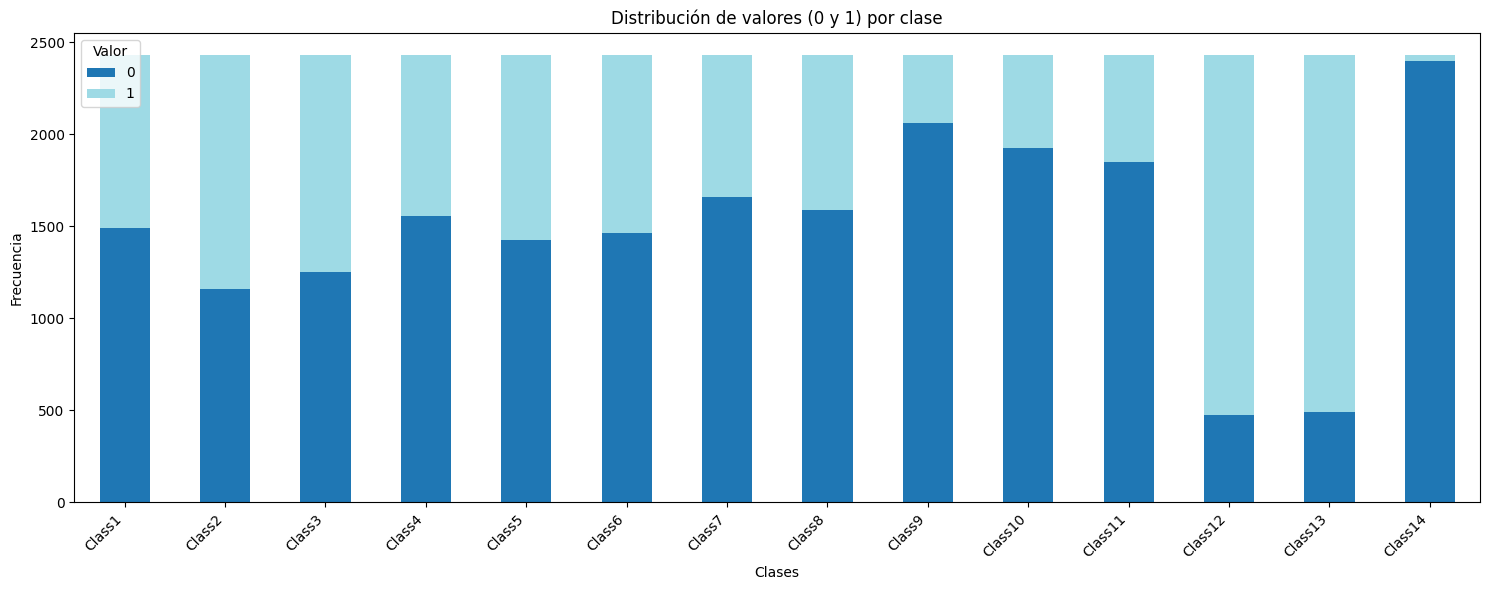

In [46]:
# Calcular counts por clase (0 y 1)
counts = Y_balanced.apply(lambda col: col.value_counts())

# # Asegurar que existen columnas 0 y 1 aunque alguna clase tenga solo un valor
counts = counts.reindex([0,1]).T.fillna(0)

# Plot apilado
plt.figure(figsize=(15, 6))
counts.plot(kind='bar', stacked=True, figsize=(15,6), colormap='tab20')

plt.title("Distribución de valores (0 y 1) por clase")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.legend(["0", "1"], title="Valor")
plt.tight_layout()
plt.show()

Parece que no hemos conseguido solucionar el problema del desbalanceo, pero sí hemos podido mitigarlo en gran parte de las clases. Las clases 10 y 11 han mejorado muy levemente, sin embargo, estas siguen mostrando un desbalanceo bastante pronunciado. Por otro lado, las clases 9 y 14 siguen igual de desbalanceadas y las clases 12 y 13 incluso han empeorado, pasando ambas de una proporción 75/25 a una 80/20. 

Veamos cómo se comportan ahora nuestros modelos al ser entrenados.

In [47]:
#Convertimos los datos en categóricos para el siguiente apartado
Y_balanced = Y_balanced.astype(bool)
Y_balanced.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,False,True,True,False,False,False,False,False,False,False,False,True,True,False
1,False,False,True,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,True,True,False
3,True,True,False,False,False,False,False,False,False,False,False,True,True,False
4,False,False,False,False,True,True,True,True,False,False,False,False,False,False


## Extra-trees  <a class="anchor" id="trees-2"></a>
Vemos cómo responde extra-trees con los datos balanceados.

In [ ]:
# Construimos el modelo con valores por defecto
extraTrees = ExtraTreesClassifier(n_estimators=100, criterion='gini', min_samples_leaf=1, min_samples_split=2, random_state=semilla)
#Entrenamos el modelo
extraTrees.fit(X_balanced, Y_balanced)
#Vemos las métricas

print("SCORE - Accuracy hard:",extraTrees.score(X_test, Y_test))
# Hacemos las predicciones
predichos = extraTrees.predict(X_test)
# Medimos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.15163934426229508
Hamming Loss:  0.198
F1-micro : 0.636
F1-macro : 0.357


Mejora los resultados hasta el momento vistos con este modelo con los datos sin balancear, siendo incluso similares al modelo baseline pero no mejores. Tenemos `una accuracy del 15.16%, una pérdida de Hamming de 0.198 y una F1-micro de 0.636`.

## XGBoost  <a class="anchor" id="xgboost-2"></a>

Veamos ahora cómo funciona el modelo XGBoost con los datos balanceados.

In [49]:
# Creamos nuestro modelo XGBoost con valores default
xgboost = MultiOutputClassifier(XGBClassifier(eta=0.3,max_depth=6, min_child_weight=1,max_leaves=0,n_estimators=100,random_state=semilla,nthread=2))
#Entrenamos el modelo
xgboost.fit(X_balanced, Y_balanced)
#Vemos la score
print("SCORE - Accuracy hard:",xgboost.score(X_test, Y_test))
# Hacemos predicciones
predichos = xgboost.predict(X_test)
# Sacamos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.14549180327868852
Hamming Loss:  0.202
F1-micro : 0.654
F1-macro : 0.424


Obtenemos `una accuracy de 14.55%, una pérdida de Hamming de 0.202 y una F1-micro de 0.654`. En comparación con el modelo entrenado con los datos sin balancea, mejoramos las medidas de F1-score, pero tenemos una pérdida de Hamming algo peor.

## MLP  <a class="anchor" id="mlp"></a>

Vemos cómo actúa el MLP con los datos balanceados.

In [50]:
#Creamos nuestro modelo con valores por defecto.
mlp = MLPClassifier(hidden_layer_sizes=(100,100),learning_rate='constant', learning_rate_init=0.001, max_iter=300,early_stopping=True, random_state=semilla)
#Entrenamos el modelo
mlp.fit(X_balanced, Y_balanced)
# Vemos las métricas
print("SCORE - Accuracy hard:",mlp.score(X_test, Y_test))
#Hacemos las predicciones
predichos = mlp.predict(X_test)
#Medimos las métricas
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.15163934426229508
Hamming Loss:  0.203
F1-micro : 0.653
F1-macro : 0.409


Obtenemos una `accuracy del 15.16%, una pérdida de Hamming de 0.203 y una F1-micro de 0.653`. Con el MLP obtenemos datos algo similares al modelo con datos sin balancear, pero mejores que con PCA. Quizás este sea el modelo más sensible al correcto ajuste de hiperparámetros.

# Balanceo de datos con extracción de características  <a class="anchor" id="balanceo-caracteristicas"></a>

No podemos realizar al mismo tiempo balanceo de datos y extracción de características. El balanceo de datos debemos de hacerlo después de haber separado el dataset entre train y test, pues no tendría sentido agregar muestras artificiales al conjunto de test. Sin embargo, el PCA debemos hacerlo antes de dividir entre ambos, puesto que tampoco tendría sentido hacer el análisis de componentes principales de estos dos por separado, necesitamos el conjunto entero. Por tanto, existe un conflicto en el orden de aplicación de los métodos. Además, opinamos que no tiene sentido sobremuestrear datos ya previamente transformados. Sería crear datos sintéticos sobre dimensiones ya transformadas artificialmente. Por tanto, concluimos que no debemos realizar balanceo de datos con *oversampling* y PCA al mismo tiempo.


En el resto del trabajo continuaremos utilizando el conjunto de datos balanceado, puesto que ha sido el que mejores resultados nos ha ofrecido hasta el momento.

# Optimización de hiperparámetros de los modelos  <a class="anchor" id="hyper"></a>

Pasamos ahora a entrenar los mejores modelos posibles optimizando sus hiperparámetros. Utilizaremos gridSearch para realizar el ajuste fino. Usaremos el dataset balanceado por ser el que mejores resultados nos ha dado hasta el momento. Además, haremos validación cruzada con 5 pliegues.


## Extra-trees  <a class="anchor" id="trees-3"></a>

Generamos el grid de hiperparámetros de extra-trees.

In [51]:
#Creamos el grid de hiperparámetros
param_grid_extraTrees = {
    'n_estimators': [100, 200,400],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2, 4]
}
#Hacemos validación cruzada de 5 folds
cv_extraTrees = GridSearchCV(
    estimator=ExtraTreesClassifier(random_state=semilla, n_jobs=-1),
    param_grid=param_grid_extraTrees,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_micro'
)
#Entreanmos los modelos y mostramos el mejor
cv_extraTrees.fit(X_balanced, Y_balanced)
extraTrees_grid = cv_extraTrees.best_estimator_
print(cv_extraTrees.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


Los parámetros del mejor modelo son criterion: entropy; min_samples_leaf: 1; min_samples_split: 2 y número de estimadores: 400.

In [52]:
#Vemos las métricas
print("SCORE - Accuracy hard:",extraTrees_grid.score(X_test, Y_test))
predichos = extraTrees_grid.predict(X_test)
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.16598360655737704
Hamming Loss:  0.197
F1-micro : 0.638
F1-macro : 0.349


Tenemos una `accuracy del 16.60%, una pérdida de Hamming de 0.197 y una F1-micro de 0.638.`Obtenemos medidas algo mejores pero similares una vez ajustados los parámetros.

## XGBoost  <a class="anchor" id="xgboost-3"></a>

Ahora crearemos el grid de hiperparámetros para el modelo XGBoost.

In [53]:
#Creamos el grid de hiperparámetros
param_grid_xgboost = {
    'estimator__learning_rate': [0.3, 0.2,0.1],
    'estimator__max_depth': [3,6,9],
    'estimator__min_child_weight': [1,3,5],
}
#Hacemos validación cruzada de 5 folds
cv_xgboost = GridSearchCV(
    estimator=MultiOutputClassifier(XGBClassifier(n_estimators=100,random_state=semilla,nthread=2)),
    param_grid=param_grid_xgboost,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_micro'
)


#Entreanmos los modelos y mostramos el mejor
cv_xgboost.fit(X_balanced, Y_balanced)
xgboost_grid = cv_xgboost.best_estimator_
print(cv_xgboost.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'estimator__learning_rate': 0.3, 'estimator__max_depth': 6, 'estimator__min_child_weight': 1}


Los parámetros del mejor modelo son learning_rate: 0.3; max_depth: 6 y min_child_weight: 1.

In [54]:
#Vemos las métricas
print("SCORE - Accuracy hard:",xgboost_grid.score(X_test, Y_test))
predichos = xgboost_grid.predict(X_test)
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.14549180327868852
Hamming Loss:  0.202
F1-micro : 0.654
F1-macro : 0.424


Tenemos una `accuracy de 14.55%, una pérdida de Hamming de 0.202 y una F1-micro de 0.654.` Obtenemos los mismos resultados que con el modelo antes de ajustar los hiperpármetros.

## MLP  <a class="anchor" id="mlp-3"></a>

Hacemos la optimización de parámetros del MLP.

In [55]:
#Creamos el grid del MLP
param_grid_mlp = {'learning_rate':['constant','adaptive'],
                 'learning_rate_init':[0.01,0.001,0.0001],
                 'max_iter':[300,500],
                 'hidden_layer_sizes':[(100,100),(200,200),(300,300)],
                 #"early_stopping": [True],
                }

# Realizamos la búsqueda por validación cruzada
cv_mlp = GridSearchCV(
        
        estimator = MLPClassifier(random_state=semilla),
        param_grid = param_grid_mlp,
        cv         = 5,
        n_jobs=-1,
        verbose=2,
        scoring='f1_micro'
        )

# Entrenamos el Grid
cv_mlp.fit(X_balanced,Y_balanced)

# Mostramos los mejores parámetros

mlp_grid = cv_mlp.best_estimator_
print(cv_mlp.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'hidden_layer_sizes': (300, 300), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'max_iter': 300}


f:\UMU\Master IA\ML\practica1\.ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Los parámetros del mejor modelo son hidden_layer_sizes: (300, 300); learning_rate: constant; learning_rate_init: 0.0001 y max_iter: 300.

In [56]:
print("SCORE - Accuracy hard:",mlp_grid.score(X_test, Y_test))
predichos = mlp_grid.predict(X_test)
print('Hamming Loss: ', round(hamming_loss(Y_test, predichos),3))
print("F1-micro :", round(f1_score(Y_test, predichos, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, predichos, average="macro"),3))

SCORE - Accuracy hard: 0.17827868852459017
Hamming Loss:  0.197
F1-micro : 0.66
F1-macro : 0.448


Con el MLP mejor ajustado obtenemos `una accuracy del 17.83%, una pérdida de Hamming de 0.197 y una F1-micro de 0.66.`**Con este modelo hemos obtenido los mejores resultados de todos**, superando todas las medidas tanto del método baseline como las del MLP con los datos sin balancear (con la excepción de la pérdida de Hamming que teníamos un 0.192). 

A veces con el modelo MLP obtenemos resultados ligeramente distintos aún usando la misma semilla. En el mejor intento en otra ocasión obtuvimos los valores: 
* SCORE - Accuracy hard: 0.18237704918032788
* Hamming Loss:  0.192
* F1-micro : 0.663
* F1-macro : 0.438

# Construcción de modelo híbrido  <a class="anchor" id="hibrido"></a>

Como último paso, intentaremos crear un modelo que intente mejorar aún más los resultados. Probamos ahora a crear manualmente un modelo híbrido formado por dos clasificadores:
* Un ensamble XGBoost para predecir las 10 clases menos desbalanceadas.
* Un MLP para predecir las 4 clases más desbalanceadas (clases 9,10,11 y 14).

De esta manera, intentaremos usar el potencial del MLP para intentar clasificar y predecir sólo las clases más difíciles. Haremos, por tanto, una predicción a medias entre ambos clasificadores para cada ejemplo de test.

In [65]:

clases_mlp = [8, 9, 10, 13]   # índices de las clases más desbalanceadas
clases_xgb = [c for c in range(14) if c not in clases_mlp] # resto de clases

#Definimos los datasets separados con las etiquetas de clases
Y_mlp = Y_balanced.iloc[:, clases_mlp]
Y_xgb = Y_balanced.iloc[:, clases_xgb]

Comprobamos cómo son los nuevos conjuntos de etiquetas.

In [58]:
Y_mlp

,Class9,Class10,Class11,Class14
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
2424,True,True,True,False
2425,False,True,True,False
2426,False,True,True,False
2427,True,True,True,False


Volvemos a entrenar los dos mejores modelos ajustados con optimización de hiperparámetros.

In [ ]:
# Volvemos a entrenar los modelos xgboost y mlp con los nuevos conjuntos de clases
cv_xgboost.fit(X_balanced, Y_xgb)
cv_mlp.fit(X_balanced, Y_mlp)
# Elegimos el modelo mejor ajustado
best_xgb = cv_xgboost.best_estimator_
best_mlp = cv_mlp.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Hacemos ahora la predicción por partes.

In [67]:
#Hacemos las predicciones separadas
pred_xgb = best_xgb.predict(X_test)  # shape: (n, 10)
pred_mlp = best_mlp.predict(X_test)  # shape: (n, 4)

Reconstruimos la matriz con las predicciones.

In [68]:
# Matriz final vacía
pred_final = np.zeros((len(X_test), 14))

# Rellenamos con predicciones de XGB y MLP
pred_final[:, clases_xgb] = pred_xgb
pred_final[:, clases_mlp] = pred_mlp

Vemos cómo queda la predicción final.

In [69]:
pred_final

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]], shape=(488, 14))

Medimos las métricas de evaluación.

In [70]:
print("SCORE - Accuracy hard:",accuracy_score(Y_test, pred_final))
print('Hamming Loss: ', round(hamming_loss(Y_test, pred_final),3))
print("F1-micro :", round(f1_score(Y_test, pred_final, average="micro"),3))
print("F1-macro :", round(f1_score(Y_test, pred_final, average="macro"),3))

SCORE - Accuracy hard: 0.15368852459016394
Hamming Loss:  0.209
F1-micro : 0.646
F1-macro : 0.432


Con este modelo híbrido obtenemos una `accuracy del 15.37%, una pérdida de Hamming de 0.209 y una F1-micro de 0.646.` No conseguimos superar los resultados anteriores del MLP ajustado, que son los mejores que hemos obtenido en todo el proceso.

# Elección del mejor modelo  <a class="anchor" id="eleccion"></a>

Al final, los modelos ajustados con búsqueda de hiperparámetros son los que mejores resultados nos han dado de entre todos los probados. En resumen, los resultados obtenidos con ellos han sido:

|    Métrica   | Baseline K-vecinos (datos sin balancear) | Extra-trees | XGBoost |   MLP  | Modelo híbrido (XGBoost + MLP) |
|:------------:|:----------------------------------------:|:-----------:|:-------:|:------:|:------------------------------:|
|   Accuracy   |                  20.57%                  |    16.60%   |  14.55% | 17.83% |             15.37%             |
| Hamming Loss |                   0.206                  |    0.197    |  0.202  |  0.197 |              0.209             |
|   F1-micro   |                   0.637                  |    0.638    |  0.654  |  0.66  |              0.646             |
|   F1-macro   |                   0.414                  |    0.349    |  0.424  |  0.448 |              0.432             |

El MLP obtenido a través del grid de parámetros nos ha dado el mejor resultado de entre los 3 principales modelos probados. También ha conseguido superar el rendimiento del modelo híbrido creado. Además, hemos conseguido superar las métricas del modelo baseline, que era uno de nuestros objetivos establecidos. La única medida que ha no sufrido mejoras ha sido la de *accuracy*, pero como ya hemos explicado anteriormente, esto no resulta un problema puesto que esta métrica no está reflejando correctamente cómo de bien está prediciendo nuestro clasificador. 

Por tanto, el modelo elegido para nuestro problema de clasificación de enfermedades será **el MLP ajustado con búsqueda de hiperparámetros**, puesto que nos ofrece el mejor rendimiento de todos. Es cierto que, si nos basásemos en criterios como la explicabilidad del modelo, podríamos elegir el modelo extra-trees o XGBoost puesto que las mejoras que obtenemos con el MLP son ligeras. Sin embargo, como ya indicamos previamente, en este problema la medida que más nos interesa es sobre todo F1-score, puesto que esta engloba la precisión y la sensibilidad, y lo que queremos es tener el mínimo número de falsos negativos posibles. Por estas razones nos quedamos con el modelo MLP.


# Conclusión  <a class="anchor" id="conclusion"></a>

Como conclusión podemos ver que los problemas de tipo multietiqueta presentan grandes dificultades a la hora de abordar ejercicios de clasficación. Esto se debe al hecho de cada instancia presenta una gran cantidad de clases. Podemos ver cómo el mejor modelo de entre todos ha sido el MLP entrenado con los datos balanceados y haciendo ajuste de hiperparámetros. Ha mejorado ligeramente el modelo baseline e incluso al modelo híbrido que pensábamos tendría un mejor rendimiento sobre todos. Podemos concluir que la extracción de características ha sido perjudicial para el rendmiento de todos los modelos. El balanceo con MultilabelSMOTE, por otra parte, parece que ha sido beneficioso para el rendimiento de todos los modelos. Por estos motivos, el mejor preprocesado ha sido el que usa división estratificado y balanceo sin PCA.

# Consultas a IA generativa  <a class="anchor" id="generativa"></a>

1. ***¿Cómo leo en python con pandas un archivo csv con los nombres de las columnas en otro archivo .name? El archivo .name tiene los nombres en formato @attribute Att1 numeric @attribute Class1 {0,1}.***

**Respuesta**: ✔️ Código en Python
        import pandas as pd

        columnas = []

        with open("archivo.name", "r") as f:
            for line in f:
                line = line.strip()
                if line.lower().startswith("@attribute"):
                    # Separa la línea por espacios
                    partes = line.split()
                    # El nombre del atributo es la segunda parte
                    nombre = partes[1]
                    columnas.append(nombre)

        # Ahora lee el CSV sin encabezado y usa la lista de columnas
        df = pd.read_csv("archivo.csv", header=None, names=columnas)

        print(df.head())

2. ***Hacer boxplot de 103 clases predictoras para que se puedan ver bien en notebook jupyter.***

**Respuesta**: Opción 2: Boxplots por lotes (ej. 10 por figura)

Mucho más práctico cuando 103 gráficos es demasiado.

        import matplotlib.pyplot as plt
        import math

        predictoras = df.columns[:103]
        batch = 10
        total = len(predictoras)
        num_figs = math.ceil(total / batch)

        for i in range(num_figs):
            subset = predictoras[i*batch : (i+1)*batch]
            plt.figure(figsize=(12, 6))
            plt.boxplot([df[col].dropna() for col in subset], labels=subset)
            plt.xticks(rotation=90)
            plt.title(f'Boxplots {i*batch + 1}–{min((i+1)*batch, total)}')
            plt.tight_layout()
            plt.show()

✔️ Produce ~10 boxplots por figura
✔️ Pueden verse bien en pantallas normales

3. ***Comprobar el plot de barras de los counts de los valores de las clases para mostrar en el mismo plot 14 clases.***

**Respuesta:** Perfecto: aquí tienes la forma correcta de mostrar en un único plot las 14 clases con sus counts (0 y 1) usando un solo gráfico, totalmente legible.

El mejor formato para multilabel es un barplot apilado (stacked):

cada clase es una barra

la parte inferior = número de ceros

la parte superior = número de unos

Así se ven las 14 clases simultáneamente en un mismo plot.

✅ Código para un solo plot con las 14 clases
        import pandas as pd
        import matplotlib.pyplot as plt

        # Calcular counts por clase (0 y 1)
        counts = Y.apply(lambda col: col.value_counts())

        # Asegurar que existen columnas 0 y 1 aunque alguna clase tenga solo un valor
        counts = counts.reindex([0,1]).T.fillna(0)

        # Plot apilado
        plt.figure(figsize=(15, 6))
        counts.plot(kind='bar', stacked=True, figsize=(15,6), colormap='tab20')

        plt.title("Distribución de valores (0 y 1) por clase")
        plt.xlabel("Clases")
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45, ha="right")
        plt.legend(["0", "1"], title="Valor")
        plt.tight_layout()
        plt.show()

📊 ¿Qué verás?

Una única gráfica con 14 barras (una por clase).

Cada barra tiene dos segmentos:

parte inferior → número de 0

parte superior → número de 1

Gracias al stacked plot puedes comparar fácilmente el balanceo entre clases.

# Librerías utilizadas  <a class="anchor" id="librerias"></a>

In [71]:
import session_info
# En versiones más recientes de python (3.12.7), este es el comando

session_info.show()
